In [ ]:
import os 
import random 
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.font_manager import fontManager
import hashlib
import pandas as pd
import random
import re
import os
import time
import json
from pprint import pprint
from config import CRITIC_MODELS, IDEA_MODELS
from utils.LLM import create_llm
from utils.utils import stable_hash, timeout_handler, run_with_timeout, append_content_new



FLUENCY_EVAL_METHOD = 'llm' # llm jaccard embedding_dense embedding_sparse tfidf

df = pd.read_parquet('./data/data.parquet')

In [ ]:
colors = ['#28abaf','#66ccff','#EE0000','#006666','#FFFF00','#0080FF']

p = './assets/fonts/Roboto_Condensed/static'
import os
all_font_flie_names = os.listdir(p)
all_ttf_file_names = [n for n in all_font_flie_names if n.endswith('.ttf')]

for ttf_file_name in all_ttf_file_names:
    fontManager.addfont(path=os.path.join(p,ttf_file_name))


# sns.set_style("white")
plt.rcParams['font.family'] = ['sans-serif'] 
plt.rcParams['font.sans-serif'] = ['Roboto Condensed'] 
plt.rcParams['font.size'] = 13


In [3]:
from config import IDEA_MODELS, CRITIC_MODELS

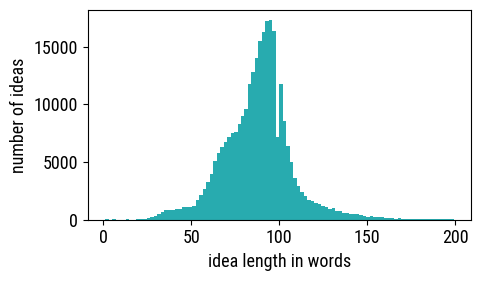

In [ ]:
df['idea_length_in_char'] = df['idea'].apply(lambda x: len(str(x)))
# Only ideas with < 2500 characters are considered valid
df = df[df['idea_length_in_char'] < 2500]
# Only ideas with > 100 characters are considered valid
df = df[df['idea_length_in_char'] > 100]

df['idea_length_in_words'] = df['idea'].apply(lambda x: len(str(x).split()))
df['idea_length_in_words'].describe()
# Limit to only ideas with < 200 words
df = df[df['idea_length_in_words'] < 200]
df = df[df['idea_model'].isin(IDEA_MODELS)]
# Plot a histogram

plt.figure(figsize=(5,3))
plt.hist(df['idea_length_in_words'], bins=100, color='#28abaf')
plt.xlabel('idea length in words')
plt.ylabel('number of ideas')
plt.tight_layout() # Add this line
plt.savefig('figs/idea_length_in_words.pdf')
plt.show()

In [5]:
df['idea_hash'] = df['idea'].apply(stable_hash)
# # df

In [ ]:
# Read JSON from file and convert to DataFrame
df_fluency = pd.read_json(f"./data/idea_hash_{FLUENCY_EVAL_METHOD}.json")
# df_fluency = pd.read_json(f"./data/idea_hash.json")

In [7]:
hash_to_score = {}

In [8]:
for i, row in df_fluency.iterrows():
    a = row['hash_A']
    b = row['hash_B']
    hash_to_score[a] = row['score']
    hash_to_score[b] = row['score']

In [9]:
len(hash_to_score)

93862

In [10]:
df['flue'] = df['idea_hash'].map(hash_to_score)
# df

In [11]:
df['flue'].isna().sum() / len(df)

np.float64(0.018855674853049998)

In [12]:
df['flue'].unique().tolist()

[3.3333, 6.6667000000000005, 10.0, nan, 0.0]

In [ ]:
mapping = {
    0: 1,
    3.3333: 4,
    6.6667000000000005: 7,
    10: 10
}

# Use the replace method to replace the values in the column
df['flue'] = df['flue'].replace(mapping)

In [14]:
ls = df['flue'].unique().tolist()
print(ls)

[4.0, 7.0, 10.0, nan, 1.0]


In [15]:
assert 1.0 in ls 
assert 4.0 in ls 
assert 7.0 in ls 
assert 10.0 in ls 


In [ ]:

def confidence_interval(mean, std_dev, n, confidence_level=0.95):
    # Adjust to sample standard deviation
    sample_std_dev = std_dev * np.sqrt(n / (n - 1))
    
    # Standard error
    standard_error = sample_std_dev / np.sqrt(n)
    
    # z-value (for large samples, close to normal distribution)
    z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Confidence interval
    lower_bound = mean - z_value * standard_error
    upper_bound = mean + z_value * standard_error
    
    return lower_bound, upper_bound

In [17]:

df_view=df.groupby('idea_model').agg({'flue':['mean'],'feasibility':['mean'],'originality':['mean'],'clarity':['mean']}).sort_values(by=('flue','mean'),ascending=False)


In [ ]:
# First, calculate the mean and standard deviation for each group
df_view = df.groupby('idea_model').agg({
    'flue': ['mean', 'std'],
    'feasibility': ['mean', 'std'],
    'originality': ['mean', 'std'],
    'clarity': ['mean', 'std']
})

# Separately calculate the sample size (number of rows) for each group
group_sizes = df.groupby('idea_model').size()

# Add a sample size column for each metric
for metric in ['flue', 'feasibility', 'originality', 'clarity']:
    df_view[(metric, 'n')] = group_sizes

# Calculate the lower and upper bounds of the confidence interval for each metric
for metric in ['flue', 'feasibility', 'originality', 'clarity']:
    # Add the lower bound of the confidence interval
    df_view[(metric, 'ci_low')] = df_view.apply(
        lambda row: confidence_interval(
            row[(metric, 'mean')],
            row[(metric, 'std')],
            row[(metric, 'n')]
        )[0],
        axis=1
    ).round(2)
    
    # Add the upper bound of the confidence interval
    df_view[(metric, 'ci_high')] = df_view.apply(
        lambda row: confidence_interval(
            row[(metric, 'mean')],
            row[(metric, 'std')],
            row[(metric, 'n')]
        )[1],
        axis=1
    ).round(2)

# Sort the dataframe in descending order by the mean of the 'flue' metric
df_view = df_view.sort_values(by=('flue', 'mean'), ascending=False)

# You can adjust the order of the columns as needed
new_order = []
for metric in ['flue', 'feasibility', 'originality', 'clarity']:
    new_order.extend([(metric, 'mean'), (metric, 'std'), (metric, 'n'), (metric, 'ci_low'), (metric, 'ci_high')])

df_view = df_view[new_order]

In [19]:
df['avg'] = (df['flue'] + df['feasibility'] + df['originality'] + df['clarity']) / 4
# df

In [20]:
df = df[df['idea_model'].isin(IDEA_MODELS)]

In [21]:
df_kw_region = pd.read_csv('./csvs/keyword_classifications.csv')
df_kw_region.columns = ['keywords','category','similarity_score']

In [ ]:
def clean_model_name(name):
    # Handle the path, remove the part before the "/"
    if '/' in name:
        name = name.split('/', 1)[1]  # Split only once, take the second part
    
    # Handle specific suffixes
    if ':' in name:
        base_name, suffix = name.split(':', 1)
        # Only remove the suffix when it is a specific type
        if suffix in ['Q4_K_M', 'free']:
            return base_name
        # Otherwise, keep the full name, including the colon and suffix
        return name
    
    return name

In [23]:
df_kw_region.columns

Index(['keywords', 'category', 'similarity_score'], dtype='object')

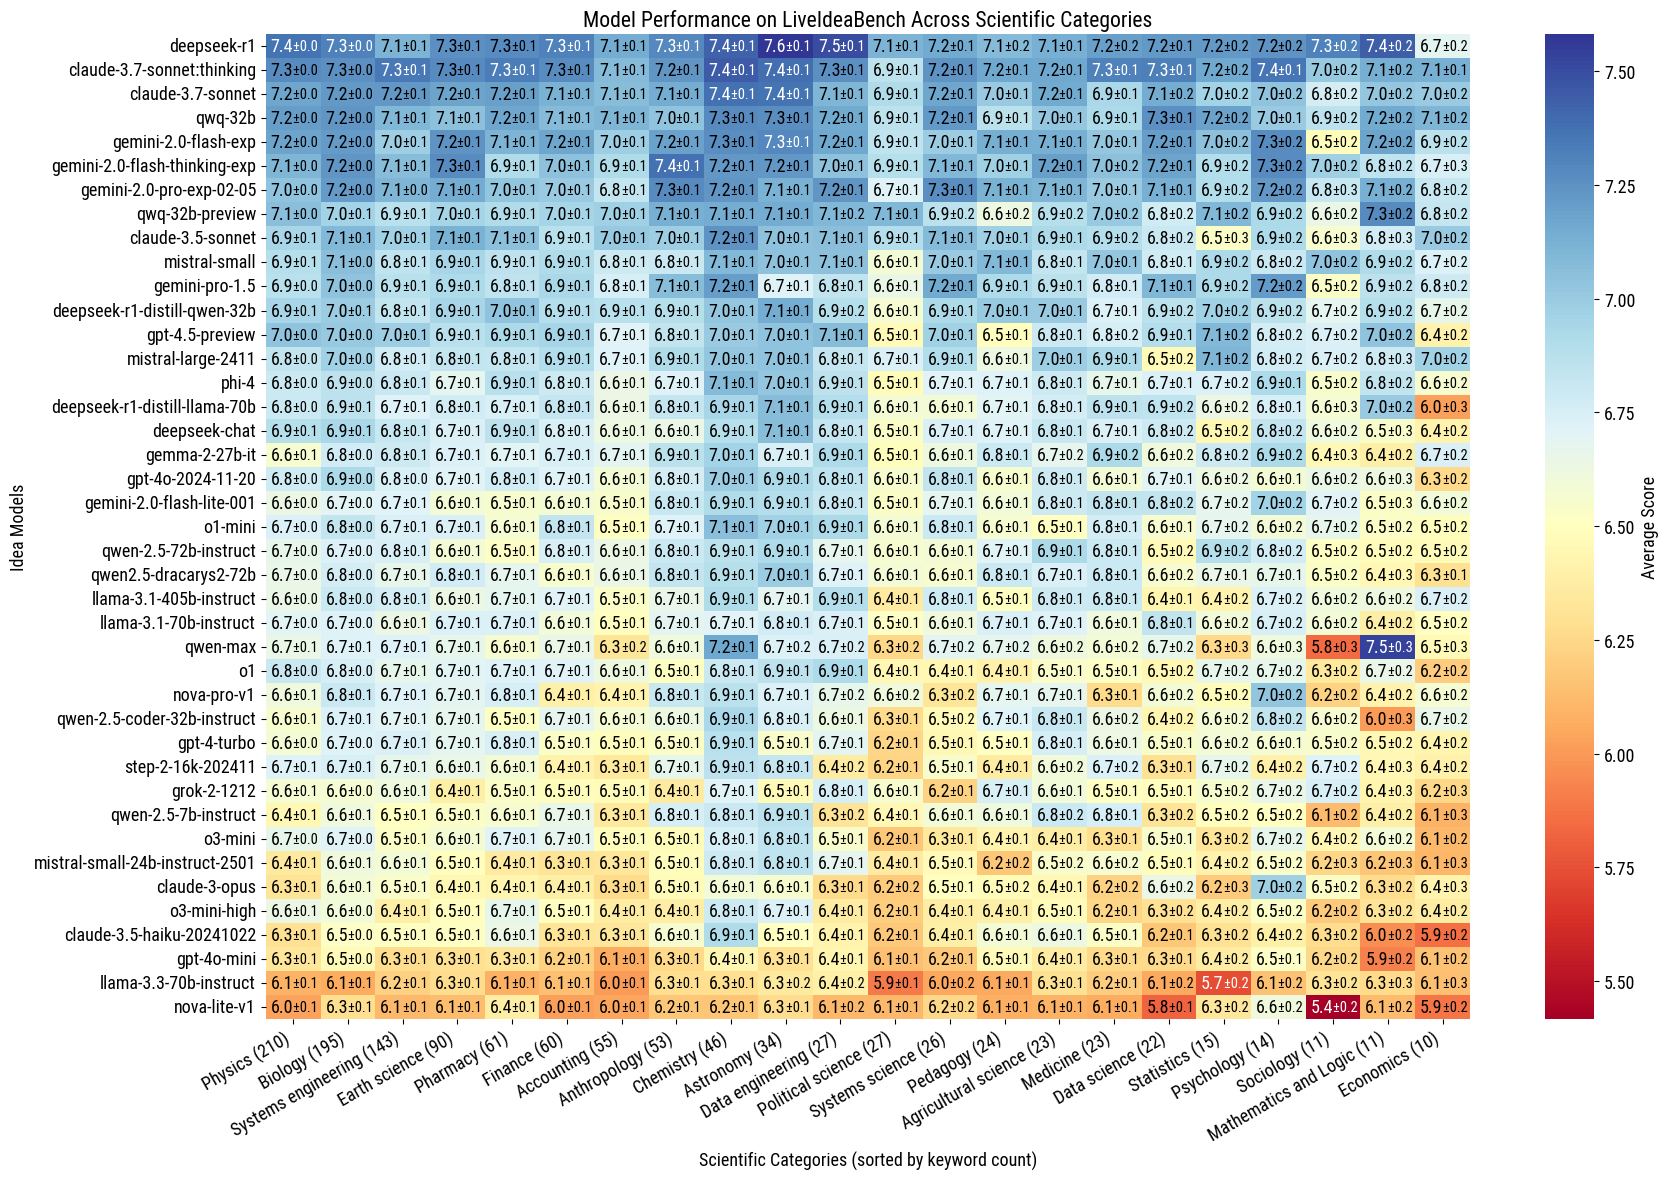

In [ ]:
# 1. Merge DataFrame
merged_df = pd.merge(df, df_kw_region, on='keywords', how='left')

# 2. Calculate the mean and confidence interval for each model and category combination
def calculate_ci(data, confidence=0.95):
    # Remove NaN values
    data = np.array(data)
    data = data[~np.isnan(data)]
    
    if len(data) < 2:  # If there are too few data points
        if len(data) == 1:
            return 0.0  # No variability when there is only one data point
        else:
            return None  # No data points
    
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Use unbiased estimator
    n = len(data)
    
    # Use t-distribution to calculate 95% confidence interval
    from scipy import stats
    t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_value * (std_dev / np.sqrt(n))
    
    return margin_error

# Prepare a dataframe to store the means and confidence intervals
stats_data = []

# Collect all the means and confidence intervals
for (model, category), group in merged_df.groupby(['idea_model', 'category']):
    # Filter out NaN values
    valid_data = group['avg'].dropna().values
    
    if len(valid_data) > 0:
        mean_val = np.mean(valid_data)
        ci_range = calculate_ci(valid_data)
        
        stats_data.append({
            'idea_model': model,
            'category': category,
            'mean': mean_val,
            'ci_range': ci_range,
            'sample_size': len(valid_data)
        })

stats_df = pd.DataFrame(stats_data)

# 3. Calculate the number of keywords for each category
category_keyword_counts = df_kw_region['category'].value_counts().to_dict()

# Sort the categories by keyword count
sorted_categories = sorted(category_keyword_counts.keys(), 
                          key=lambda x: category_keyword_counts[x], 
                          reverse=True)  # Sort from high to low

# Create a pivot table for the means
pivot_mean = stats_df.pivot_table(
    values='mean',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# Create a pivot table for the confidence intervals
pivot_ci = stats_df.pivot_table(
    values='ci_range',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# Create a pivot table for the sample sizes, for debugging purposes
pivot_samples = stats_df.pivot_table(
    values='sample_size',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# 4. Rename the indices
pivot_mean.index = pivot_mean.index.map(clean_model_name)
pivot_ci.index = pivot_ci.index.map(clean_model_name)
pivot_samples.index = pivot_samples.index.map(clean_model_name)

# Reorder the columns by keyword count
# Filter out any categories that may not be present in the pivot tables
available_categories = [cat for cat in sorted_categories if cat in pivot_mean.columns]
pivot_mean = pivot_mean[available_categories]
pivot_ci = pivot_ci[available_categories]
pivot_samples = pivot_samples[available_categories]

# 5. Calculate the overall average score for each model and sort
# Use nanmean to avoid the impact of missing values on the average score calculation
model_means = pivot_mean.apply(lambda x: np.nanmean(x), axis=1)
ordered_models = model_means.sort_values(ascending=False).index

# Sort based on the average scores
pivot_mean = pivot_mean.loc[ordered_models]
pivot_ci = pivot_ci.loc[ordered_models]
pivot_samples = pivot_samples.loc[ordered_models]

# Create new column names, including the keyword count for each category
new_column_names = [f"{col} ({category_keyword_counts.get(col, 0)})" for col in pivot_mean.columns]

# Rename the columns
pivot_mean.columns = new_column_names
pivot_ci.columns = new_column_names
pivot_samples.columns = new_column_names

# 6. Create a heatmap - adjust the figure size to be a bit wider
plt.figure(figsize=(18, 12))  # Adjust the aspect ratio to be wider

# Define the colormap and normalization - exclude NaN values for normalization
vmin = np.nanmin(pivot_mean.values)
vmax = np.nanmax(pivot_mean.values)
cmap = plt.cm.RdYlBu
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Plot the heatmap (without annotations)
ax = sns.heatmap(pivot_mean, annot=False, mask=np.isnan(pivot_mean), 
                cmap=cmap, norm=norm, cbar_kws={'label': 'Average Score'})

# Improved text color determination function - use the brightness of the colormap
def get_text_color(value, norm, cmap):
    # Get the color based on the value
    rgba = cmap(norm(value))
    # Calculate the brightness (simplified) - use the weighted average of RGB
    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    # Use white text for low brightness, black text for high brightness
    return 'white' if brightness < 0.5 else 'black'

# Manually add annotations with confidence intervals - make the confidence interval text smaller
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        if i < len(pivot_mean.index) and j < len(pivot_mean.columns):
            mean_val = pivot_mean.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(mean_val):
                continue
            
            # Get the text color that contrasts with the background
            text_color = get_text_color(mean_val, norm, cmap)
            
            # Get the base font size
            base_font_size = plt.rcParams['font.size']
            
            # Get the confidence interval value (if it exists and is not NaN)
            ci_text = ""
            if i < len(pivot_ci.index) and j < len(pivot_ci.columns):
                ci_val = pivot_ci.iloc[i, j]
                if not pd.isna(ci_val):
                    ci_text = f"±{ci_val:.1f} "
            
            # Plot the mean - normal size
            ax.text(j + 0.5, i + 0.5, f"{mean_val:.1f}", 
                   ha="right", va="center", color=text_color,
                   fontsize=base_font_size)
            
            # Plot the confidence interval - smaller font
            ax.text(j + 0.5, i + 0.5, f"{ci_text}", 
                   ha="left", va="center", color=text_color,
                   fontsize=base_font_size * 0.8)  # Reduce the font size to 80%

# 7. Set the chart style
plt.title('Model Performance on LiveIdeaBench Across Scientific Categories')
plt.xlabel('Scientific Categories (sorted by keyword count)')
plt.ylabel('Idea Models')

# 8. Rotate the x-axis labels
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)

# 9. Adjust the layout
plt.tight_layout()
plt.savefig('figs/sci_cat.pdf', bbox_inches='tight')

# Display the chart
plt.show()

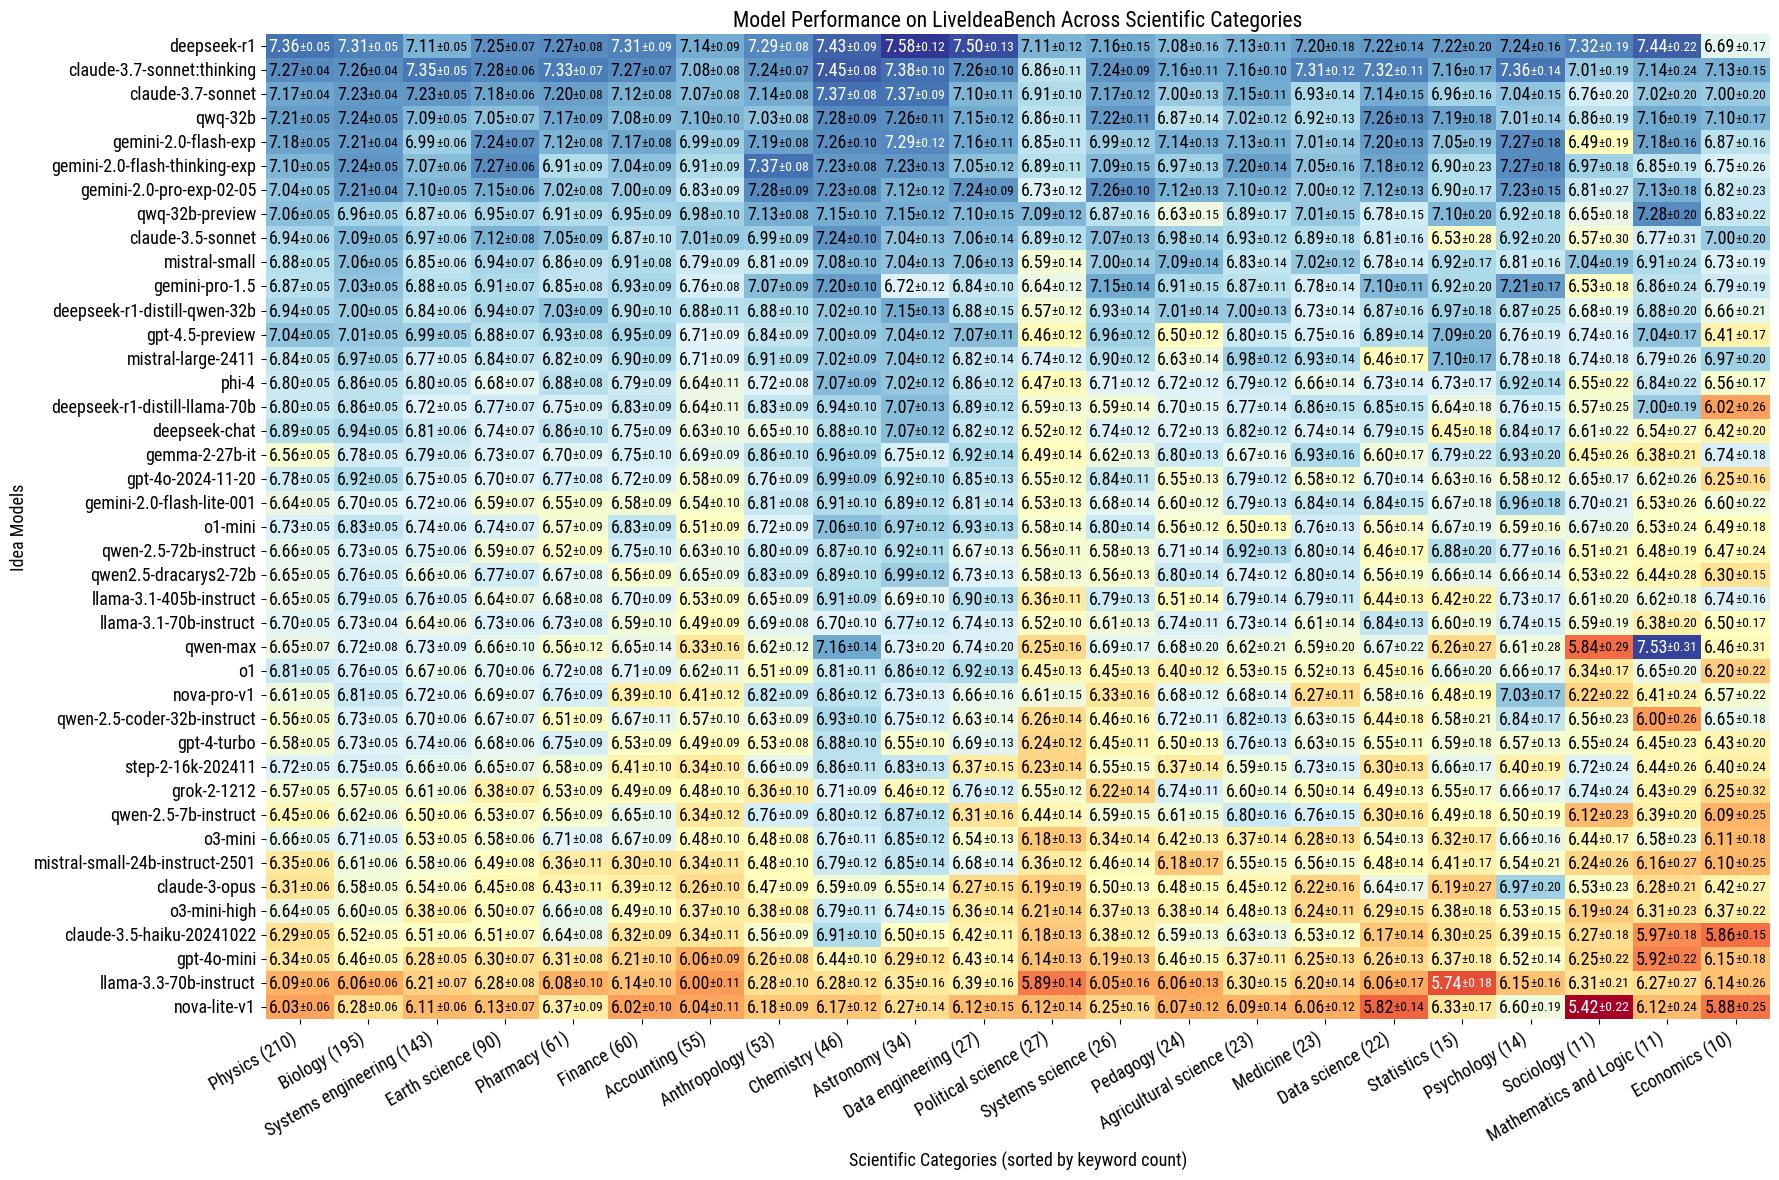

In [ ]:
# 1. Merge DataFrame
merged_df = pd.merge(df, df_kw_region, on='keywords', how='left')

# 2. Calculate the mean and confidence interval for each model and category combination
def calculate_ci(data, confidence=0.95):
    # Remove NaN values
    data = np.array(data)
    data = data[~np.isnan(data)]

    if len(data) < 2:  # If there are too few data points
        if len(data) == 1:
            return 0.0  # No variability when there is only one data point
        else:
            return None  # No data points

    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Use unbiased estimator
    n = len(data)

    # Use t-distribution to calculate 95% confidence interval
    # from scipy import stats # Already imported above
    t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_value * (std_dev / np.sqrt(n))

    return margin_error

# Prepare a dataframe to store the means and confidence intervals
stats_data = []

# Collect all the means and confidence intervals
for (model, category), group in merged_df.groupby(['idea_model', 'category']):
    # Filter out NaN values
    valid_data = group['avg'].dropna().values

    if len(valid_data) > 0:
        mean_val = np.mean(valid_data)
        ci_range = calculate_ci(valid_data)

        stats_data.append({
            'idea_model': model,
            'category': category,
            'mean': mean_val,
            'ci_range': ci_range,
            'sample_size': len(valid_data)
        })

stats_df = pd.DataFrame(stats_data)

# 3. Calculate the number of keywords for each category
category_keyword_counts = df_kw_region['category'].value_counts().to_dict()

# Sort the categories by keyword count
sorted_categories = sorted(category_keyword_counts.keys(),
                          key=lambda x: category_keyword_counts[x],
                          reverse=True)  # Sort from high to low

# Create a pivot table for the means
pivot_mean = stats_df.pivot_table(
    values='mean',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# Create a pivot table for the confidence intervals
pivot_ci = stats_df.pivot_table(
    values='ci_range',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# Create a pivot table for the sample sizes, for debugging
pivot_samples = stats_df.pivot_table(
    values='sample_size',
    index='idea_model',
    columns='category',
    aggfunc='first'
)

# 4. Rename the indices
pivot_mean.index = pivot_mean.index.map(clean_model_name)
pivot_ci.index = pivot_ci.index.map(clean_model_name)
pivot_samples.index = pivot_samples.index.map(clean_model_name)

# Reorder the columns by keyword count
# Filter out any categories that may not be present in the pivot tables
available_categories = [cat for cat in sorted_categories if cat in pivot_mean.columns]
pivot_mean = pivot_mean[available_categories]
pivot_ci = pivot_ci[available_categories]
pivot_samples = pivot_samples[available_categories]

# 5. Calculate the overall average score for each model and sort
# To avoid the impact of missing values on the average score calculation, we use nanmean
model_means = pivot_mean.apply(lambda x: np.nanmean(x), axis=1)
ordered_models = model_means.sort_values(ascending=False).index

# Sort based on the average score
pivot_mean = pivot_mean.loc[ordered_models]
pivot_ci = pivot_ci.loc[ordered_models]
pivot_samples = pivot_samples.loc[ordered_models]

# Create new column names that include the keyword counts for each category
new_column_names = [f"{col} ({category_keyword_counts.get(col, 0)})" for col in pivot_mean.columns]

# Rename the columns
pivot_mean.columns = new_column_names
pivot_ci.columns = new_column_names
pivot_samples.columns = new_column_names

# 6. Create a heatmap - Adjust the figure size to be a bit wider
# MODIFICATION 1: Increase width to 120% (18 * 1.2 = 21.6)
plt.figure(figsize=(18, 12))  # Original was (18, 12)

# Define the colormap and normalization - Exclude NaN values for normalization
vmin = np.nanmin(pivot_mean.values)
vmax = np.nanmax(pivot_mean.values)
cmap = plt.cm.RdYlBu
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Plot the heatmap (without annotations)
# MODIFICATION 2: Remove color bar by setting cbar=False and removing cbar_kws
ax = sns.heatmap(pivot_mean, annot=False, mask=np.isnan(pivot_mean),
                cmap=cmap, norm=norm, cbar=False) # Removed cbar_kws and added cbar=False

# Improved text color determination function - Use the colormap's brightness
def get_text_color(value, norm, cmap):
    # Get the color based on the value
    rgba = cmap(norm(value))
    # Calculate the brightness (simplified) - Use the weighted average of RGB
    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    # Brightness threshold, use white text for low brightness, black text for high brightness
    return 'white' if brightness < 0.5 else 'black'

# Manually add annotations with confidence intervals - Make the confidence interval text smaller
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        if i < len(pivot_mean.index) and j < len(pivot_mean.columns):
            mean_val = pivot_mean.iloc[i, j]

            # Skip NaN values
            if pd.isna(mean_val):
                continue

            # Get the text color that contrasts with the background color
            text_color = get_text_color(mean_val, norm, cmap)

            # Get the base font size
            base_font_size = plt.rcParams['font.size']

            # Get the confidence interval value (if it exists and is not NaN)
            ci_text = ""
            if i < len(pivot_ci.index) and j < len(pivot_ci.columns):
                ci_val = pivot_ci.iloc[i, j]
                if not pd.isna(ci_val) and ci_val is not None: # Added check for None
                    ci_text = f"±{ci_val:.2f} "

            # Plot the mean - Normal size
            ax.text(j + 0.5, i + 0.5, f"{mean_val:.2f}",
                   ha="right", va="center", color=text_color,
                   fontsize=base_font_size)

            # Plot the confidence interval - Smaller font
            ax.text(j + 0.5, i + 0.5, f"{ci_text}",
                   ha="left", va="center", color=text_color,
                   fontsize=base_font_size * 0.75)  # Reduce the font size to 75%

# 7. Set the chart style
plt.title('Model Performance on LiveIdeaBench Across Scientific Categories')
plt.xlabel('Scientific Categories (sorted by keyword count)')
plt.ylabel('Idea Models')

# 8. Rotate the x-axis labels
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)

# 9. Adjust the layout
plt.tight_layout()
# Make sure the 'figs' directory exists or change the save path
plt.savefig('figs/sci_cat_2_digits.pdf', bbox_inches='tight')

# Display the chart
plt.show()

In [26]:
pivot_ci

Physics (210)  Biology (195)  \
idea_model                                                      
deepseek-r1                           0.045471       0.046893   
claude-3.7-sonnet:thinking            0.041626       0.042241   
claude-3.7-sonnet                     0.044898       0.043563   
qwq-32b                               0.046346       0.045160   
gemini-2.0-flash-exp                  0.045414       0.041505   
gemini-2.0-flash-thinking-exp         0.047419       0.045004   
gemini-2.0-pro-exp-02-05              0.045288       0.042491   
qwq-32b-preview                       0.049787       0.050773   
claude-3.5-sonnet                     0.055259       0.053957   
mistral-small                         0.052418       0.045748   
gemini-pro-1.5                        0.048232       0.048145   
deepseek-r1-distill-qwen-32b          0.050747       0.050546   
gpt-4.5-preview                       0.045725       0.046955   
mistral-large-2411                    0.048856       0.046040   
phi-4                                 0.046870       0.045646   
deepseek-r1-distill-llama-70b         0.048981       0.053388   
deepseek-chat                         0.050259       0.051345   
gemma-2-27b-it                        0.052074       0.048496   
gpt-4o-2024-11-20                     0.046282       0.045263   
gemini-2.0-flash-lite-001             0.048862       0.047139   
o1-mini                               0.048665       0.046149   
qwen-2.5-72b-instruct                 0.048357       0.048210   
qwen2.5-dracarys2-72b                 0.048645       0.046367   
llama-3.1-405b-instruct               0.047378       0.046916   
llama-3.1-70b-instruct                0.049731       0.044199   
qwen-max                              0.073611       0.076671   
o1                                    0.047215       0.048041   
nova-pro-v1                           0.054938       0.054653   
qwen-2.5-coder-32b-instruct           0.053537       0.051890   
gpt-4-turbo                           0.047801       0.045064   
step-2-16k-202411                     0.052709       0.050591   
grok-2-1212                           0.051956       0.047996   
qwen-2.5-7b-instruct                  0.057163       0.055091   
o3-mini                               0.048376       0.048172   
mistral-small-24b-instruct-2501       0.062004       0.055842   
claude-3-opus                         0.057715       0.050525   
o3-mini-high                          0.050283       0.047081   
claude-3.5-haiku-20241022             0.052554       0.045510   
gpt-4o-mini                           0.052147       0.047025   
llama-3.3-70b-instruct                0.059621       0.056865   
nova-lite-v1                          0.055792       0.056055   

                                 Systems engineering (143)  \
idea_model                                                   
deepseek-r1                                       0.054587   
claude-3.7-sonnet:thinking                        0.050360   
claude-3.7-sonnet                                 0.050428   
qwq-32b                                           0.054509   
gemini-2.0-flash-exp                              0.057706   
gemini-2.0-flash-thinking-exp                     0.055585   
gemini-2.0-pro-exp-02-05                          0.049462   
qwq-32b-preview                                   0.061752   
claude-3.5-sonnet                                 0.064313   
mistral-small                                     0.056900   
gemini-pro-1.5                                    0.053073   
deepseek-r1-distill-qwen-32b                      0.060073   
gpt-4.5-preview                                   0.054558   
mistral-large-2411                                0.053956   
phi-4                                             0.051681   
deepseek-r1-distill-llama-70b                     0.054586   
deepseek-chat                                     0.057935   
gemma-2-27b-it                                    0.056857 

In [ ]:
def get_model_flexibility_with_ci(idea_model, percentile=0.3, n_bootstrap=10000, confidence=0.95, plot=False):
    """
    Calculate the model flexibility (specific percentile) and its confidence interval using the bootstrap method. (According to the keywords, it means that the flexibility needs to be evenly developed in various fields in order to be high.)
    
    Parameters:
    idea_model: The name of the model to be analyzed
    percentile: The percentile to be calculated (default is 0.3, i.e., the 30th percentile)
    n_bootstrap: Number of bootstrap iterations (default is 1000)
    confidence: Confidence interval level (default is 0.95, i.e., 95% confidence interval)
    plot: Whether to plot the distribution graph (default is False)
    
    Returns:
    percentile_value: The percentile of the original data
    ci_lower: Lower bound of the confidence interval
    ci_upper: Upper bound of the confidence interval
    """
    # Extract data for the specific model and filter out NaN values
    view = df[df['idea_model'] == idea_model]

    model_data = view.groupby('keywords').agg({'feasibility':'mean','originality':'mean','flue':'mean','clarity':'mean'}).dropna().values.mean(axis=1)
    
    # Check if there are enough data points
    if len(model_data) < 5:  # Set a minimum threshold
        print(f"Warning: The model '{idea_model}' has too few valid data points ({len(model_data)})")
        return np.nan, np.nan, np.nan
    
    # Calculate the percentile of the original data
    percentile_value = np.percentile(model_data, percentile * 100)
    print('percentile_value', percentile_value)
    
    # Perform bootstrap sampling
    bootstrap_percentiles = []
    np.random.seed(42)  # Set the random seed to ensure reproducibility
    from tqdm import tqdm
    for _ in tqdm(range(n_bootstrap)):
        # Random sampling with replacement, sample size is the same as the original data
        bootstrap_sample = np.random.choice(model_data, size=len(model_data), replace=True)
        # Calculate the percentile of this sample
        bootstrap_percentile = np.percentile(bootstrap_sample, percentile * 100)
        bootstrap_percentiles.append(bootstrap_percentile)
    
    # Calculate the confidence interval
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_percentiles, alpha * 100)
    ci_upper = np.percentile(bootstrap_percentiles, (1 - alpha) * 100)
    
    # Visualize (if needed)
    if plot:
        plt.figure(figsize=(10, 6))
        
        # Original data distribution
        plt.subplot(2, 1, 1)
        sns.histplot(model_data, kde=True, color='purple')
        plt.axvline(x=percentile_value, color='red', linestyle='--')
        plt.title(f'{idea_model} Data Distribution and {percentile*100}% Percentile')
        plt.xlabel('Mean Value')
        
        # Bootstrap percentile distribution
        plt.subplot(2, 1, 2)
        sns.histplot(bootstrap_percentiles, kde=True, color='blue')
        plt.axvline(x=percentile_value, color='red', linestyle='--', label=f'Original {percentile*100}% Percentile')
        plt.axvline(x=ci_lower, color='green', linestyle=':', label=f'Confidence Interval Lower Bound')
        plt.axvline(x=ci_upper, color='green', linestyle=':', label=f'Confidence Interval Upper Bound')
        plt.title(f'Bootstrap Calculated {percentile*100}% Percentile Distribution (n={n_bootstrap})')
        plt.xlabel(f'{percentile*100}% Percentile Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    
    return percentile_value, ci_lower, ci_upper

# Ensure that the df_view has the necessary columns
# Initialize in the same way as the original code
df_view[('flex', 'mean')] = None

# Add confidence interval columns
df_view[('flex', 'ci_lower')] = None
df_view[('flex', 'ci_upper')] = None

# Calculate the flexibility and confidence interval for each model
print(f"Starting to calculate the flexibility indicators for {len(df['idea_model'].unique())} models...")
for i, model in enumerate(df['idea_model'].unique()):
    print(f"Processing ({i+1}/{len(df['idea_model'].unique())}) {model}")
    
    # Use the bootstrap method to calculate the flexibility and confidence interval
    flexibility, ci_lower, ci_upper = get_model_flexibility_with_ci(
        model, percentile=0.3, n_bootstrap=10000, plot=False)
    
    # Update the df_view in the same way as the original code
    df_view.loc[model, ('flex', 'mean')] = flexibility
    df_view.loc[model, ('flex', 'ci_lower')] = ci_lower
    df_view.loc[model, ('flex', 'ci_upper')] = ci_upper

# Calculate the average in the same way as the original code
df_view['avg'] = df_view[[('flex','mean'),('feasibility','mean'), ('originality','mean'),('flue','mean'),('clarity','mean')]].mean(axis=1)
df_view = df_view.sort_values(by='avg',ascending=False)

# Handle the column names in the same way as the original code
df_view_result = df_view.copy()
df_view_result.columns = df_view_result.columns.map('_'.join)

# Print the results
print("\nCalculation results:")
print(df_view_result[['flex_mean', 'flex_ci_lower', 'flex_ci_upper']].head())

# Return the results for further use
df_view_result

开始计算 41 个模型的灵活性指标...
处理 (1/41) qwen/qwq-32b
percentile_value 6.75


 49%|████▉     | 4912/10000 [00:00<00:00, 7175.65it/s]

100%|██████████| 10000/10000 [00:01<00:00, 8330.22it/s]


处理 (2/41) google/gemini-2.0-flash-exp:free
percentile_value 6.833333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9768.52it/s]


处理 (3/41) google/gemini-2.0-flash-thinking-exp:free
percentile_value 6.833333333333333


100%|██████████| 10000/10000 [00:01<00:00, 8782.86it/s]


处理 (4/41) deepseek/deepseek-chat
percentile_value 6.375


100%|██████████| 10000/10000 [00:01<00:00, 6539.99it/s]


处理 (5/41) deepseek/deepseek-r1-distill-llama-70b
percentile_value 6.413541666666666


100%|██████████| 10000/10000 [00:01<00:00, 6563.90it/s]


处理 (6/41) qwen/qwq-32b-preview
percentile_value 6.708333333333333


100%|██████████| 10000/10000 [00:01<00:00, 7196.40it/s]


处理 (7/41) anthropic/claude-3.7-sonnet:thinking
percentile_value 7.041666666666666


100%|██████████| 10000/10000 [00:01<00:00, 9828.41it/s]


处理 (8/41) google/gemini-2.0-pro-exp-02-05:free
percentile_value 6.75


100%|██████████| 10000/10000 [00:01<00:00, 8189.24it/s]


处理 (9/41) deepseek/deepseek-r1
percentile_value 6.833333333333334


100%|██████████| 10000/10000 [00:01<00:00, 7531.16it/s]


处理 (10/41) anthropic/claude-3.5-haiku-20241022
percentile_value 6.083333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9000.77it/s]


处理 (11/41) deepseek/deepseek-r1-distill-qwen-32b
percentile_value 6.625


100%|██████████| 10000/10000 [00:01<00:00, 6640.42it/s]


处理 (12/41) openai/o1
percentile_value 6.291666666666667


100%|██████████| 10000/10000 [00:01<00:00, 7254.69it/s]


处理 (13/41) openai/gpt-4.5-preview
percentile_value 6.541666666666666


100%|██████████| 10000/10000 [00:01<00:00, 7896.27it/s]


处理 (14/41) mistralai/mistral-large-2411
percentile_value 6.5


100%|██████████| 10000/10000 [00:01<00:00, 8205.17it/s]


处理 (15/41) openai/o3-mini-high
percentile_value 6.166666666666666


100%|██████████| 10000/10000 [00:01<00:00, 9781.83it/s]


处理 (16/41) amazon/nova-lite-v1
percentile_value 5.708333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9771.32it/s]


处理 (17/41) sammcj/qwen2.5-dracarys2-72b:Q4_K_M
percentile_value 6.333333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9715.00it/s]


处理 (18/41) meta-llama/llama-3.1-405b-instruct
percentile_value 6.333333333333334


100%|██████████| 10000/10000 [00:01<00:00, 8031.70it/s]


处理 (19/41) openai/o3-mini
percentile_value 6.208333333333334


100%|██████████| 10000/10000 [00:01<00:00, 6775.77it/s]


处理 (20/41) openai/gpt-4o-2024-11-20
percentile_value 6.375


100%|██████████| 10000/10000 [00:01<00:00, 6819.33it/s]


处理 (21/41) openai/gpt-4o-mini
percentile_value 6.0


100%|██████████| 10000/10000 [00:01<00:00, 7851.59it/s]


处理 (22/41) google/gemma-2-27b-it
percentile_value 6.375


100%|██████████| 10000/10000 [00:01<00:00, 9206.57it/s]


处理 (23/41) mistralai/mistral-small-24b-instruct-2501
percentile_value 6.124999999999999


100%|██████████| 10000/10000 [00:01<00:00, 8223.51it/s]


处理 (24/41) openai/gpt-4-turbo
percentile_value 6.25


100%|██████████| 10000/10000 [00:01<00:00, 9037.94it/s]


处理 (25/41) mistralai/mistral-small
percentile_value 6.625


100%|██████████| 10000/10000 [00:01<00:00, 9808.22it/s]


处理 (26/41) openai/o1-mini
percentile_value 6.333333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9799.86it/s]


处理 (27/41) meta-llama/llama-3.1-70b-instruct
percentile_value 6.375


100%|██████████| 10000/10000 [00:01<00:00, 7274.55it/s]


处理 (28/41) qwen/qwen-2.5-72b-instruct
percentile_value 6.291666666666667


100%|██████████| 10000/10000 [00:01<00:00, 7974.51it/s]


处理 (29/41) x-ai/grok-2-1212
percentile_value 6.166666666666666


100%|██████████| 10000/10000 [00:01<00:00, 8178.23it/s]


处理 (30/41) google/gemini-2.0-flash-lite-001
percentile_value 6.25


100%|██████████| 10000/10000 [00:01<00:00, 9601.79it/s]


处理 (31/41) qwen/qwen-2.5-coder-32b-instruct
percentile_value 6.25


100%|██████████| 10000/10000 [00:01<00:00, 9244.52it/s]


处理 (32/41) qwen/qwen-2.5-7b-instruct
percentile_value 6.166666666666666


100%|██████████| 10000/10000 [00:01<00:00, 9431.13it/s]


处理 (33/41) qwen/qwen-max
percentile_value 6.291666666666666


100%|██████████| 10000/10000 [00:00<00:00, 11756.11it/s]


处理 (34/41) anthropic/claude-3.5-sonnet
percentile_value 6.625


100%|██████████| 10000/10000 [00:00<00:00, 11681.15it/s]


处理 (35/41) step-2-16k-202411
percentile_value 6.208333333333333


100%|██████████| 10000/10000 [00:01<00:00, 9746.07it/s]


处理 (36/41) microsoft/phi-4
percentile_value 6.416666666666667


100%|██████████| 10000/10000 [00:01<00:00, 7696.73it/s]


处理 (37/41) google/gemini-pro-1.5
percentile_value 6.583333333333333


100%|██████████| 10000/10000 [00:01<00:00, 7494.13it/s]


处理 (38/41) meta-llama/llama-3.3-70b-instruct
percentile_value 5.75


100%|██████████| 10000/10000 [00:01<00:00, 9687.68it/s]


处理 (39/41) anthropic/claude-3.7-sonnet
percentile_value 6.916666666666667


100%|██████████| 10000/10000 [00:01<00:00, 9285.92it/s]


处理 (40/41) anthropic/claude-3-opus
percentile_value 6.041666666666667


100%|██████████| 10000/10000 [00:01<00:00, 7676.61it/s]


处理 (41/41) amazon/nova-pro-v1
percentile_value 6.25


100%|██████████| 10000/10000 [00:01<00:00, 9786.45it/s]


计算结果:
                                     flex_mean flex_ci_lower flex_ci_upper
idea_model                                                                
anthropic/claude-3.7-sonnet:thinking  7.041667      6.966667      7.083333
deepseek/deepseek-r1                  6.833333      6.791667      6.916667
anthropic/claude-3.7-sonnet           6.916667         6.875      6.958333
google/gemini-2.0-flash-exp:free      6.833333          6.75         6.875
qwen/qwq-32b                              6.75      6.666667      6.791667


flue_mean  flue_std  flue_n  \
idea_model                                                               
anthropic/claude-3.7-sonnet:thinking        7.477186  2.200663    7107   
deepseek/deepseek-r1                        6.632233  2.460356    7098   
anthropic/claude-3.7-sonnet                 7.798558  2.210982    7097   
google/gemini-2.0-flash-exp:free            7.304751  2.354228    7095   
qwen/qwq-32b                                6.453136  2.316800    7073   
google/gemini-2.0-flash-thinking-exp:free   7.381429  2.419074    7106   
google/gemini-2.0-pro-exp-02-05:free        6.844599  2.317593    7107   
qwen/qwq-32b-preview                        7.494463  2.247223    6670   
anthropic/claude-3.5-sonnet                 6.898178  2.447725    5919   
deepseek/deepseek-r1-distill-qwen-32b       7.057188  2.252330    6728   
mistralai/mistral-small                     7.363223  2.365591    7113   
google/gemini-pro-1.5                       6.677949  2.503020    7105   
openai/gpt-4.5-preview                      6.485154  2.407015    7113   
mistralai/mistral-large-2411                6.681314  2.508946    7112   
deepseek/deepseek-chat                      6.148718  2.624713    7114   
microsoft/phi-4                             6.575263  2.305912    7096   
deepseek/deepseek-r1-distill-llama-70b      6.663309  2.396517    7072   
openai/gpt-4o-2024-11-20                    6.122939  2.348060    7109   
openai/o1-mini                              5.890632  2.541719    7111   
google/gemma-2-27b-it                       7.179839  2.427549    7109   
sammcj/qwen2.5-dracarys2-72b:Q4_K_M         6.221780  2.438088    7107   
meta-llama/llama-3.1-405b-instruct          6.565773  2.347514    7103   
qwen/qwen-2.5-72b-instruct                  6.165391  2.418450    7126   
meta-llama/llama-3.1-70b-instruct           6.708475  2.262174    7109   
openai/o1                                   6.230463  2.343929    7111   
google/gemini-2.0-flash-lite-001            6.733778  2.465837    7112   
qwen/qwen-max                               5.641121  2.548292    4470   
amazon/nova-pro-v1                          6.452037  2.611995    7118   
qwen/qwen-2.5-coder-32b-instruct            6.576721  2.431626    7108   
openai/gpt-4-turbo                          6.136858  2.431456    7108   
step-2-16k-202411                           5.704361  2.943432    7090   
openai/o3-mini                              5.567101  2.322327    7111   
qwen/qwen-2.5-7b-instruct                   6.660873  2.446953    7100   
x-ai/grok-2-1212                            5.763132  2.495215    7105   
openai/o3-mini-high                         5.267348  2.307177    7109   
mistralai/mistral-small-24b-instruct-2501   7.070068  2.325153    6931   
anthropic/claude-3.5-haiku-20241022         5.612811  2.335615    7101   
anthropic/claude-3-opus                     5.739063  2.731475    7090   
openai/gpt-4o-mini                          5.278591  2.301842    7115   
meta-llama/llama-3.3-70b-instruct           5.681342  2.701689    7106   
amazon/nova-lite-v1                         4.510239  2.705086    7108   

                                           flue_ci_low  flue_ci_high  \
idea_model                                                             
anthropic/claude-3.7-sonnet:thinking              7.43          7.53   
deepseek/deepseek-r1                              6.57          6.69   
anthropic/claude-3.7-sonnet                       7.75          7.85   
google/gemini-2.0-flash-exp:free                  7.25          7.36   
qwen/qwq-32b                                      6.40          6.51   
google/gemini-2.0-flash-thinking-exp:free         7.33          7.44   
google/gemini-2.0-pro-exp-02-05:free              6.79          6.90   
qwen/qwq-32b-preview                              7.44          7.55   
anthropic/claude-3.5-sonnet                       6.84          6.96   
deepseek/deepseek-r1-distill-qwen-32b             7.00          7.11

<Axes: ylabel='idea_model'>

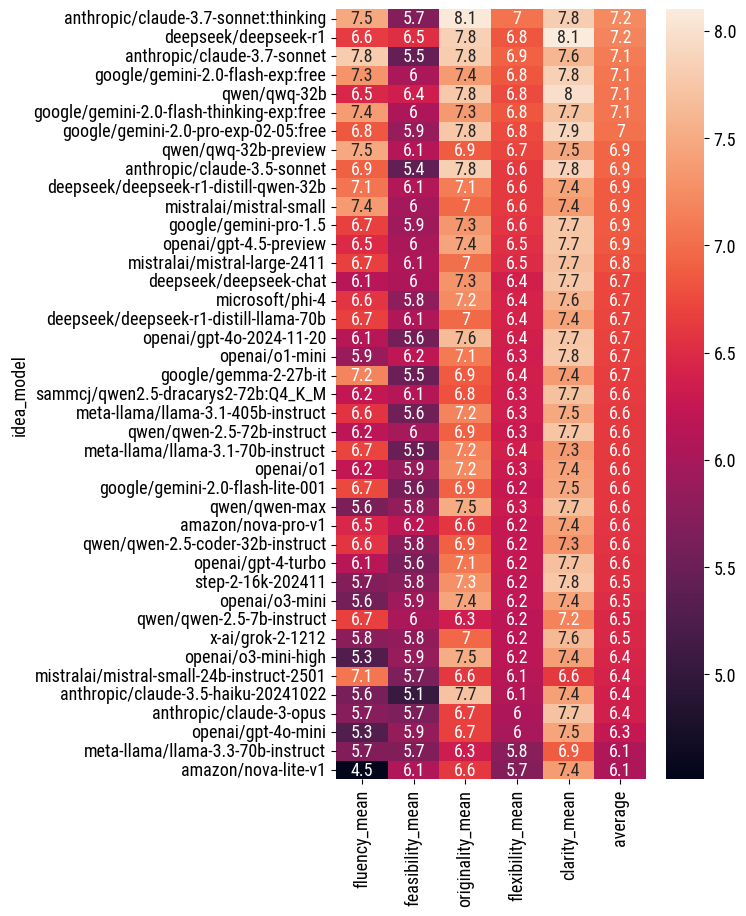

In [ ]:
# Get the current column names
df_view = df_view_result
new_columns = list(df_view.columns)

# Create a new list of column names, replacing "flue" with "fluency" and "flex" with "flexibility" in the column names that contain them, and replacing "avg_" with "average"
new_columns = [col.replace('flue', 'fluency') for col in new_columns]
new_columns = [col.replace('flex', 'flexibility') for col in new_columns]
new_columns = [col.replace('avg_', 'average') for col in new_columns]

# Rename the columns
df_view.columns = new_columns

df_view = df_view.apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(5, 10))
sns.heatmap(df_view[['fluency_mean','feasibility_mean', 'originality_mean','flexibility_mean','clarity_mean','average']], annot=True)

In [29]:
df_view.columns

Index(['fluency_mean', 'fluency_std', 'fluency_n', 'fluency_ci_low',
       'fluency_ci_high', 'feasibility_mean', 'feasibility_std',
       'feasibility_n', 'feasibility_ci_low', 'feasibility_ci_high',
       'originality_mean', 'originality_std', 'originality_n',
       'originality_ci_low', 'originality_ci_high', 'clarity_mean',
       'clarity_std', 'clarity_n', 'clarity_ci_low', 'clarity_ci_high',
       'flexibility_mean', 'flexibility_ci_lower', 'flexibility_ci_upper',
       'average'],
      dtype='object')

2025-04-09 22:37:03,370 - WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


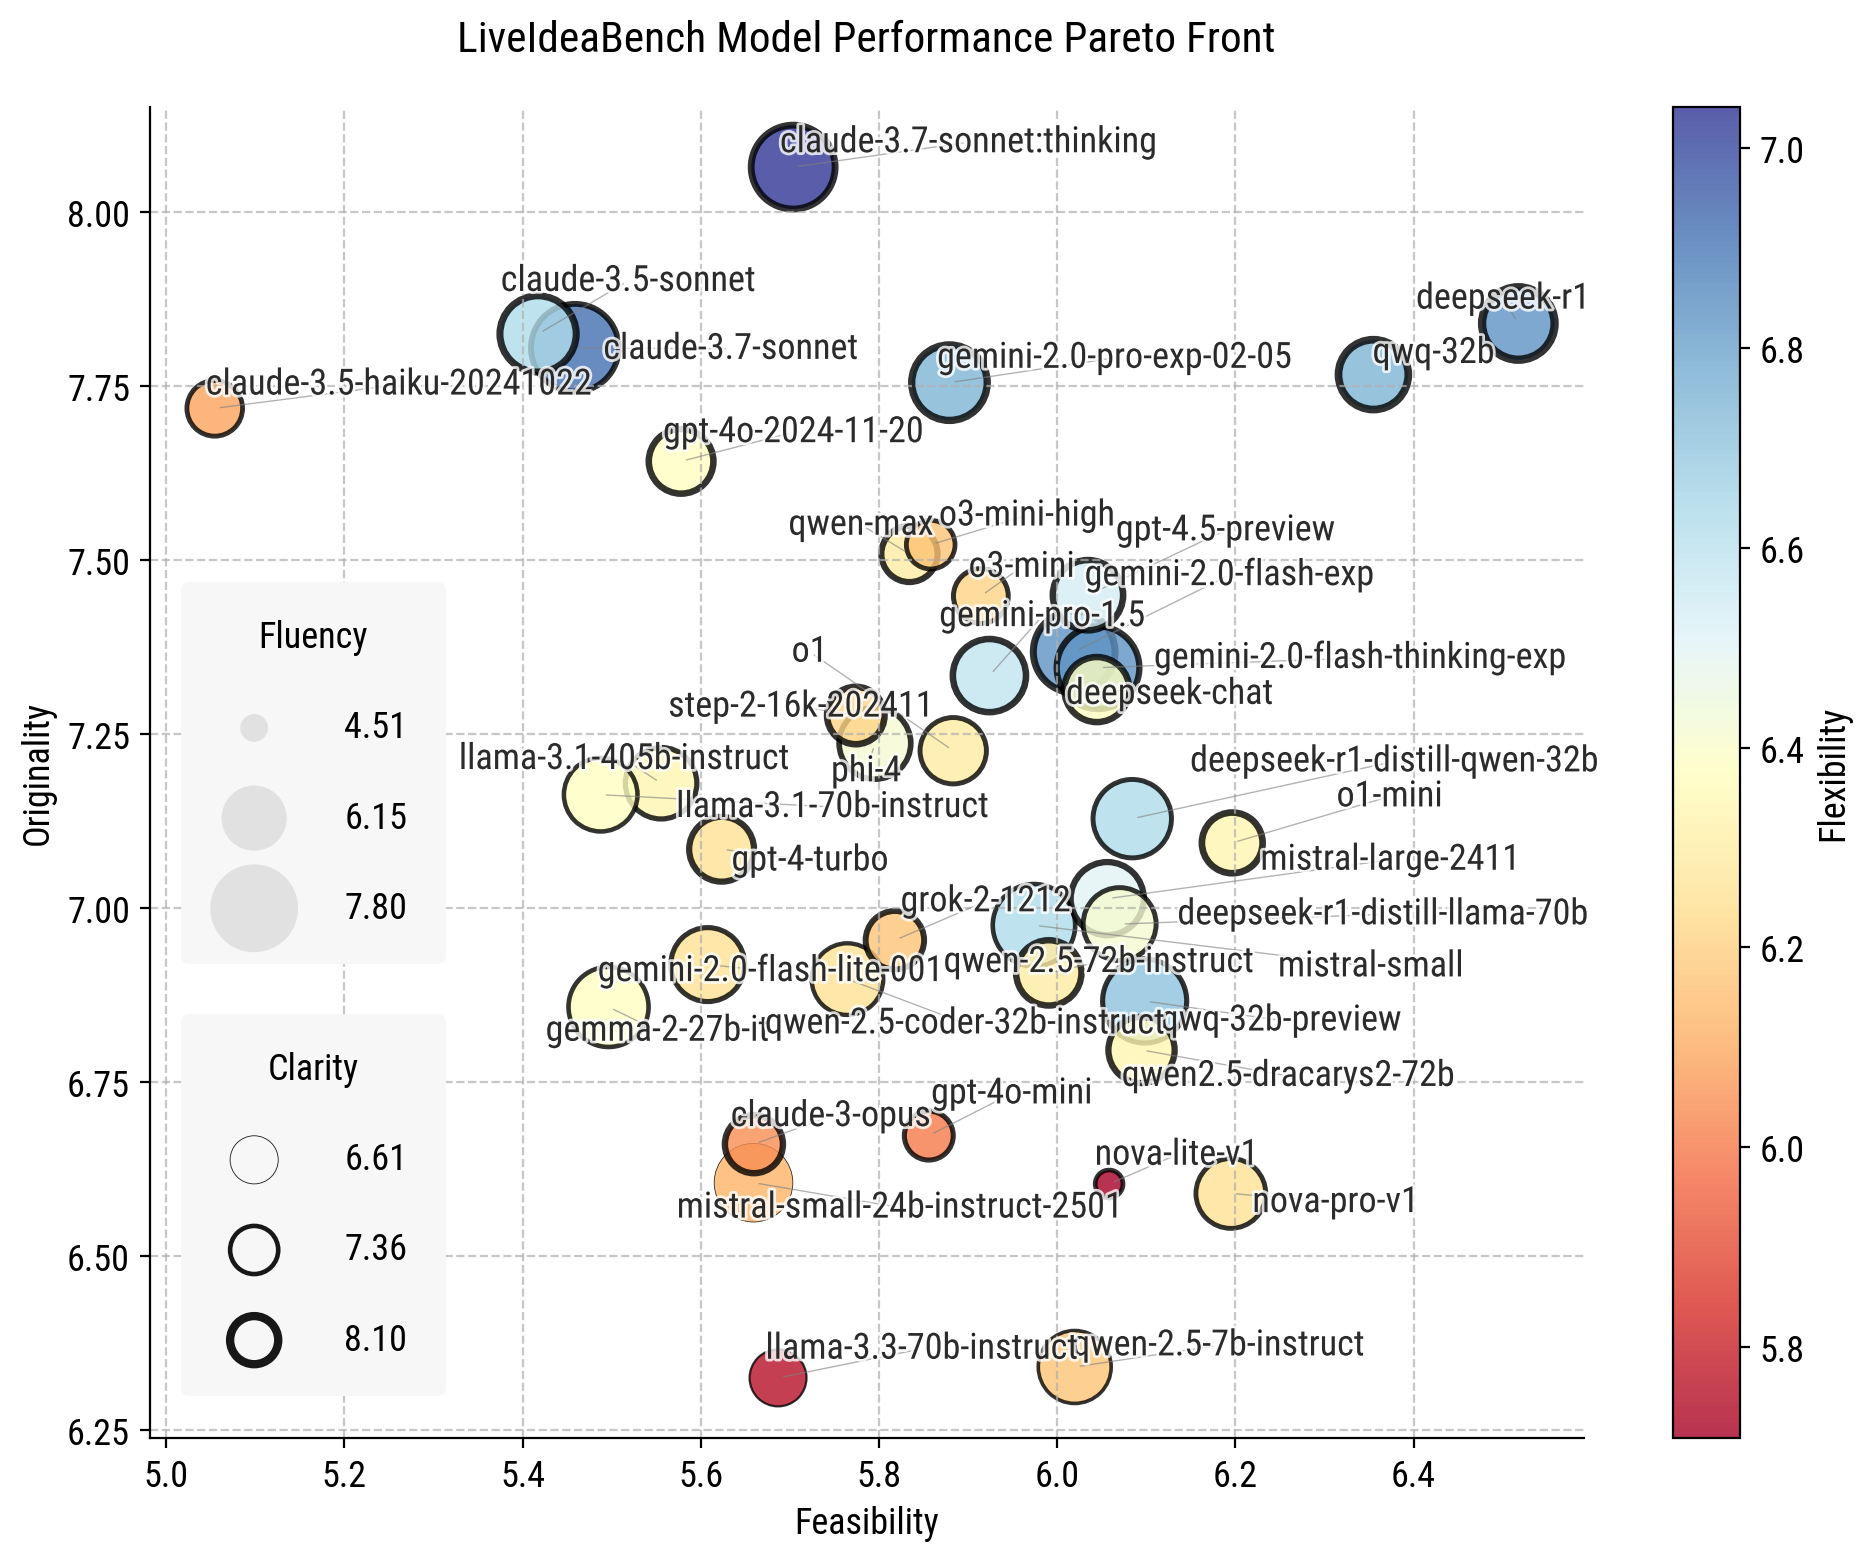

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Rectangle
from adjustText import adjust_text
import matplotlib.patheffects as pe

# Normalize bubble size
scaler_size = MinMaxScaler(feature_range=(100, 1000))
bubble_sizes = scaler_size.fit_transform(df_view['fluency_mean'].values.reshape(-1, 1)).flatten()

# Normalize edge width - use clarity as edge width
scaler_width = MinMaxScaler(feature_range=(0.3, 3))  # Edge width range from 0.3 to 3
edge_widths = scaler_width.fit_transform(df_view['clarity_mean'].values.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 8), dpi=200)

# Set style
plt.grid(True, linestyle='--', alpha=0.7)

# clarity_edge_color = 'grey'  # Edge color
clarity_edge_color = 'black'  # Edge color


# Create main scatter plot
scatter = plt.scatter(data=df_view, 
                     x='feasibility_mean', 
                     y='originality_mean',
                     s=bubble_sizes,        
                     c=df_view['flexibility_mean'],  
                     cmap = 'RdYlBu',        
                     vmin=df_view['flexibility_mean'].quantile(0.0),
                     vmax=df_view['flexibility_mean'].quantile(1.0),
                     edgecolor=clarity_edge_color,
                     linewidth=edge_widths,  # Use clarity as edge width
                     alpha=0.8)                  

# Add model name labels, but now use adjustText for optimization
texts = []
for idx, row in df_view.iterrows():
    # Create text object, default position at top right of bubble
    text = plt.text(row['feasibility_mean'], row['originality_mean'],
                    clean_model_name(idx)[:40],
                    fontsize=13,
                    alpha=0.8,
                    ha='left',
                    va='bottom',
                    zorder=10,
                    path_effects=[pe.withStroke(linewidth=2, foreground='white')])
    texts.append(text)

# Use adjust_text to adjust text positions and avoid overlaps
adjust_text(texts,
           arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
           expand_points=(1.2, 1.2),
           force_points=(0.5, 0.5),
           force_text=(0.5, 0.5),
           only_move={'points':'xy', 'texts':'xy'},
           lim=100,  # Limit iteration count
           avoid_self=True,
           avoid_points=True)

# Calculate reference values
fluency_min = df_view['fluency_mean'].min()
fluency_max = df_view['fluency_mean'].max()
fluency_mid = (fluency_min + fluency_max) / 2

clarity_min = df_view['clarity_mean'].min()
clarity_max = df_view['clarity_mean'].max()
clarity_mid = (clarity_min + clarity_max) / 2

# Create Fluency legend (bubble size)
legend_fluency = [
    plt.scatter([], [], s=scaler_size.transform([[fluency_min]])[0][0], 
               c='lightgray', alpha=0.6, edgecolor='none', label=f'{fluency_min:.2f}'),
    plt.scatter([], [], s=scaler_size.transform([[fluency_mid]])[0][0], 
               c='lightgray', alpha=0.6, edgecolor='none', label=f'{fluency_mid:.2f}'),
    plt.scatter([], [], s=scaler_size.transform([[fluency_max]])[0][0], 
               c='lightgray', alpha=0.6, edgecolor='none', label=f'{fluency_max:.2f}')
]

# Add Fluency legend to the left center
first_legend = plt.legend(handles=legend_fluency, 
          title='Fluency',
          loc='center left',
          labelspacing=1.5,  # Adjust spacing within the legend
          borderpad=1,
          handletextpad=1.5,
          framealpha=1.0,  # Opaque background
          facecolor='#f7f7f7',  # Gray background
          edgecolor='#f7f7f7',  # Gray border
          bbox_to_anchor=(0.01, 0.50)  # Move to the left and up to avoid overlap
         )

# Add the first legend to the plot
plt.gca().add_artist(first_legend)


# Create Clarity legend (edge width)
legend_clarity = [
    plt.scatter([], [], s=300, facecolor='none', edgecolor=clarity_edge_color, alpha=0.9,
               linewidth=scaler_width.transform([[clarity_min]])[0][0],
               label=f'{clarity_min:.2f}'),
    plt.scatter([], [], s=300, facecolor='none', edgecolor=clarity_edge_color, alpha=0.9,
               linewidth=scaler_width.transform([[clarity_mid]])[0][0],
               label=f'{clarity_mid:.2f}'),
    plt.scatter([], [], s=300, facecolor='none', edgecolor=clarity_edge_color, alpha=0.9,
               linewidth=scaler_width.transform([[clarity_max]])[0][0],
               label=f'{clarity_max:.2f}')
]

# Add the second legend to the bottom left
plt.legend(handles=legend_clarity, 
          title='Clarity',
          loc='lower left',
          labelspacing=1.5,  # Adjust spacing within the legend
          borderpad=1,
          handletextpad=1.5,
          framealpha=1.0,  # Opaque background
          facecolor='#f7f7f7',  # Gray background
          edgecolor='#f7f7f7',  # Gray border
          bbox_to_anchor=(0.01, 0.02)  # Move to the left and adjust down to avoid overlap
         )

# Set title and axis labels
plt.title('LiveIdeaBench Model Performance Pareto Front', pad=20)
plt.xlabel('Feasibility')
plt.ylabel('Originality')

# Add color bar
plt.colorbar(scatter, label='Flexibility')

# Remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('figs/pareto.pdf', dpi=200, bbox_inches='tight')

plt.show()

In [31]:
# df_view

In [32]:
from config import CRITIC_MODELS, IDEA_MODELS

In [ ]:


open_source_models = {
    'gemini-pro-1.5': False,
    'qwq-32b-preview': True,
    'qwq-32b': True,
    'o1-preview': False,
    'claude-3.5-sonnet': False,
    'claude-3.7-sonnet': False,
    'gemini-2.0-flash-exp': False,
    'qwen2.5-dracarys2-72b': True,
    'nova-pro-v1': False,
    'gpt-4o-2024-11-20': False,
    'mistral-large-2411': True,
    'llama-3.1-nemotron-70b-instruct': True,
    'qwen-2.5-coder-32b-instruct': True,
    'llama-3.1-405b-instruct': True,
    'o1-mini': False,
    'qwen-2.5-72b-instruct': True,
    'claude-3.5-haiku': False,
    'step-2-16k': False,
    'grok-2-1212': False,
    'gpt-4o-mini': False,
    'deepseek-chat': True,

    'deepseek-r1': True,
    'deepseek-r1-distill-llama-70b': True,

    'minimax-01': True,
    'mistral-nemo': True,
    'phi-4': True,
    'claude-3-opus': False,

    'llama-3.3-70b-instruct': True,

    'QwQ-32B-Preview-IdeaWhiz-v1': True,
    'gemini-2.0-flash-001': False,
    
    'mistral-small':True,
    
    'gemini-2.0-flash-thinking-exp':False,
    
    'deepseek-r1-distill-qwen-32b':True,
    'gemini-2.0-flash-lite-001':False,
    'codestral-2501':True,
    
    'qwen-max':False,
    'qwen-plus':False,
    'o3-mini':False,
    
    'o3-mini-high':False,
    "gemma-2-27b-it":True,
    "mistral-small-24b-instruct-2501":True,

    # small models
    'mistral-small': True,
    'qwen-2.5-7b-instruct':True,
    'phi-3-mini-128k-instruct':True,
    'llama-3.1-8b-instruct':True,
    'nova-micro-v1':False,
    'gemma-2-9b-it':True,
    'command-r-08-2024':True,
    'gemini-2.0-pro-exp-02-05':False,
    'o1':False,
    'llama-3.1-70b-instruct':True,
    'step-2-16k-202411':False,
    'gpt-4.5-preview':False,
    'claude-3.5-haiku-20241022':False,
    'gpt-4-turbo':False,
    'nova-lite-v1':False,
    'google/gemini-2.0-flash-exp:free':False,
    'anthropic/claude-3.7-sonnet':False,
    'openai/o1':False,
    'openai/o3-mini':False,
    'openai/o1-mini':False,
    'openai/gpt-4o-2024-11-20':False,
    'deepseek/deepseek-r1-distill-llama-70b':True,
    'google/gemini-pro-1.5':False,
    'x-ai/grok-2-1212':False,
    'google/gemini-2.0-flash-lite-001':False,
    'sammcj/qwen2.5-dracarys2-72b:Q4_K_M':True,
    'meta-llama/llama-3.1-405b-instruct':True,
    'qwen/qwen-2.5-72b-instruct':True,
    'openai/gpt-4-turbo':False,
    'meta-llama/llama-3.3-70b-instruct':True,
    'anthropic/claude-3-opus':False,
    'mistralai/mistral-large-2411':True,
    'qwen/qwen-2.5-coder-32b-instruct':True,
    'deepseek/deepseek-r1-distill-qwen-32b':True,
    'meta-llama/llama-3.1-70b-instruct':True,
    'amazon/nova-pro-v1':False,
    'anthropic/claude-3.5-haiku-20241022':False,
    'mistralai/mistral-small-24b-instruct-2501':True,
    'microsoft/phi-4':True,
    'openai/gpt-4o-mini':False,
    'qwen/qwq-32b-preview':True,
    'amazon/nova-lite-v1':False,
    'qwen/qwen-2.5-7b-instruct':True,
    'mistralai/mistral-small':True,
    'google/gemma-2-27b-it':True,
    'anthropic/claude-3.7-sonnet:thinking':False,
    'openai/o3-mini-high':False,
    'openai/gpt-4.5-preview':False,
    'qwen/qwq-32b':True,
    'deepseek/deepseek-r1':True,
    'google/gemini-2.0-flash-thinking-exp:free':False,
    'google/gemini-2.0-pro-exp-02-05:free':False,
    'qwen/qwen-max':False,
    'deepseek/deepseek-chat':True,
    'anthropic/claude-3.5-sonnet':False,
    'claude-3.7-sonnet:thinking':False,
    
}

In [34]:
for m in IDEA_MODELS:
    if m not in list(open_source_models.keys()):
        print(m)

In [35]:
df_view.columns

Index(['fluency_mean', 'fluency_std', 'fluency_n', 'fluency_ci_low',
       'fluency_ci_high', 'feasibility_mean', 'feasibility_std',
       'feasibility_n', 'feasibility_ci_low', 'feasibility_ci_high',
       'originality_mean', 'originality_std', 'originality_n',
       'originality_ci_low', 'originality_ci_high', 'clarity_mean',
       'clarity_std', 'clarity_n', 'clarity_ci_low', 'clarity_ci_high',
       'flexibility_mean', 'flexibility_ci_lower', 'flexibility_ci_upper',
       'average'],
      dtype='object')

In [ ]:
# Sort by the average column and generate rank
df_latex = df_view[['fluency_mean','feasibility_mean','originality_mean','clarity_mean','flexibility_mean','average']].copy().sort_values('average', ascending=False).reset_index()
df_latex.columns = ['Model', 'Fluency', 'Feasibility', 'Originality', 'Clarity','Flexibility', 'Average']
df_latex.index = range(1, len(df_latex) + 1)  # Rank starting from 1
# df_latex

In [37]:
df_latex['Model_Short'] = df_latex['Model'].apply(clean_model_name)

In [38]:
df_latex['Is_Open_Source'] = df_latex['Model_Short'].apply(lambda x: open_source_models[x])

In [39]:
df_latex.to_csv('./csvs/LiveIdeaBench.csv')

In [40]:
is_plot = True

In [41]:
model_name_map = {
    # left: Livebench name,  right: openrouter name
    'o1-preview-2024-09-12' : 'o1-preview',
    'gemini-1.5-pro-002' : 'gemini-pro-1.5',
    'grok-2-1212' : 'grok-2-1212',
    'claude-3-5-sonnet-20241022' : 'claude-3-5-sonnet',
    'gemini-2.0-flash-exp': 'gemini-2.0-flash-exp',
    'o1-mini-2024-09-12': 'o1-mini-2024-09-12',
    'gpt-4o-2024-11-20': 'gpt-4o-2024-11-20',
    'meta-llama-3.1-405b-instruct-turbo': 'llama-3.1-405b-instruct',
    'qwen2.5-72b-instruct-turbo' : 'qwen-2.5-72b-instruct',
    'llama-3.3-70b-instruct-turbo': 'llama-3.3-70b-instruct',
    
    'mistral-large-2411': 'mistral-large-2411',
    'qwen2.5-coder-32b-instruct': 'qwen-2.5-coder-32b-instruct',
    'deepseek-v2.5-1210': 'deepseek-chat',
    'amazon.nova-pro-v1:0': 'nova-pro-v1',
    'claude-3-5-haiku-20241022':'claude-3.5-haiku',
    'gpt-4o-mini-2024-07-18': 'gpt-4o-mini',
    'qwq-32b-preview':'qwq-32b-preview',

    'step-2-16k':'step-2-16k',
    # 'llama-3.1-nemotron-70b-instruct',
    
    'gemma-2-9b-it': 'gemma-2-9b-it',
    'mistral-small-2409':'mistral-small',
    'qwen2.5-7b-instruct-turbo':'qwen-2.5-7b-instruct',
    'phi-3-mini-128k-instruct':'phi-3-mini-128k-instruct',
    'meta-llama-3.1-8b-instruct-turbo':'llama-3.1-8b-instruct',
    'amazon.nova-micro-v1:0':'nova-micro-v1',
    'gemma-2-9b-it':'gemma-2-9b-it',

    'command-r-08-2024':'command-r-08-2024',
    'claude-3-7-sonnet-thinking':'claude-3.7-sonnet:thinking',
    'o3-mini-2025-01-31-high':'o3-mini-high',
    'o1-2024-12-17-high':'o1',
    'qwq-32b':'qwq-32b',
    'deepseek-r1':'deepseek-r1',
    'o3-mini-2025-01-31-medium':'o3-mini',
    'gpt-4.5-preview':'gpt-4.5-preview',
    'gemini-2.0-flash-thinking-exp-01-21':'gemini-2.0-flash-thinking-exp:free',
    'claude-3-7-sonnet':'claude-3.7-sonnet',
    'gemini-2.0-pro-exp-02-05':'google/gemini-2.0-pro-exp-02-05:free',
    'qwen2.5-max':'qwen-max',
    'gemini-2.0-flash': 'gemini-2.0-flash-exp:free',
    'deepseek-v3':'deepseek-chat',
    'step-2-16k-202411':'step-2-16k-202411',
    'deepseek-r1-distill-llama-70b':'deepseek-r1-distill-llama-70b',
    'gemini-2.0-flash-lite':'gemini-2.0-flash-lite-001',
    'dracarys2-72b-instruct':'sammcj/qwen2.5-dracarys2-72b:Q4_K_M',
    'gpt-4-turbo-2024-04-09':'gpt-4-turbo',
    'claude-3-opus-20240229':'claude-3-opus',
    'phi-4':'phi-4',
    'deepseek-r1-distill-qwen-32b':'deepseek-r1-distill-qwen-32b',
    'meta-llama-3.1-70b-instruct-turbo':'llama-3.1-70b-instruct',
    'gemma-2-27b-it':'gemma-2-27b-it',
    'mistral-small-2501':'mistral-small-24b-instruct-2501',
    
    
}

In [42]:
df_livebench1221 = pd.read_csv('./csvs/Livebench20250315.csv')
# df_livebench1221 = pd.read_csv('./LiveIdeaBench.csv')
df_livebench1221['Model_Short'] = df_livebench1221['Model'].map(model_name_map)
# df_livebench1221 = df_livebench1221.dropna()
# df_livebench1221

In [43]:
for i,row in df_livebench1221.iterrows():
    m = row['Model']
    if m not in list(model_name_map.keys()):
        print(m)

grok-3-thinking
gemini-exp-1206
o3-mini-2025-01-31-low
grok-3
chatgpt-4o-latest-2025-01-29
gpt-4o-2024-08-06
gemini-2.0-flash-lite-preview-02-05
learnlm-1.5-pro-experimental
chatgpt-4o-latest-0903
grok-beta
dracarys2-llama-3.1-70b-instruct
amazon.nova-lite-v1:0
command-r-plus-08-2024
command-r-plus-04-2024
phi-3-small-8k-instruct
olmo-2-1124-13b-instruct
phi-3-mini-4k-instruct


In [44]:
df_view.columns

Index(['fluency_mean', 'fluency_std', 'fluency_n', 'fluency_ci_low',
       'fluency_ci_high', 'feasibility_mean', 'feasibility_std',
       'feasibility_n', 'feasibility_ci_low', 'feasibility_ci_high',
       'originality_mean', 'originality_std', 'originality_n',
       'originality_ci_low', 'originality_ci_high', 'clarity_mean',
       'clarity_std', 'clarity_n', 'clarity_ci_low', 'clarity_ci_high',
       'flexibility_mean', 'flexibility_ci_lower', 'flexibility_ci_upper',
       'average'],
      dtype='object')

In [45]:
df_view.index

Index(['anthropic/claude-3.7-sonnet:thinking', 'deepseek/deepseek-r1',
       'anthropic/claude-3.7-sonnet', 'google/gemini-2.0-flash-exp:free',
       'qwen/qwq-32b', 'google/gemini-2.0-flash-thinking-exp:free',
       'google/gemini-2.0-pro-exp-02-05:free', 'qwen/qwq-32b-preview',
       'anthropic/claude-3.5-sonnet', 'deepseek/deepseek-r1-distill-qwen-32b',
       'mistralai/mistral-small', 'google/gemini-pro-1.5',
       'openai/gpt-4.5-preview', 'mistralai/mistral-large-2411',
       'deepseek/deepseek-chat', 'microsoft/phi-4',
       'deepseek/deepseek-r1-distill-llama-70b', 'openai/gpt-4o-2024-11-20',
       'openai/o1-mini', 'google/gemma-2-27b-it',
       'sammcj/qwen2.5-dracarys2-72b:Q4_K_M',
       'meta-llama/llama-3.1-405b-instruct', 'qwen/qwen-2.5-72b-instruct',
       'meta-llama/llama-3.1-70b-instruct', 'openai/o1',
       'google/gemini-2.0-flash-lite-001', 'qwen/qwen-max',
       'amazon/nova-pro-v1', 'qwen/qwen-2.5-coder-32b-instruct',
       'openai/gpt-4-turbo', 's

In [46]:
df_merge = pd.merge(df_latex, df_livebench1221, on='Model_Short')
df_merge.columns

Index(['Model_x', 'Fluency', 'Feasibility', 'Originality', 'Clarity',
       'Flexibility', 'Average', 'Model_Short', 'Is_Open_Source', 'Model_y',
       'Organization', 'Global Average', 'Reasoning Average', 'Coding Average',
       'Mathematics Average', 'Data Analysis Average', 'Language Average',
       'IF Average'],
      dtype='object')

In [47]:
df_merge.index

RangeIndex(start=0, stop=34, step=1)

In [48]:
numeric_cols = ['Fluency', 'Feasibility', 'Originality','Clarity','Flexibility','Average','Global Average','Reasoning Average','Coding Average','Mathematics Average','Data Analysis Average','Language Average','IF Average']
df_merge[numeric_cols] = df_merge[numeric_cols].apply(pd.to_numeric, errors='coerce')

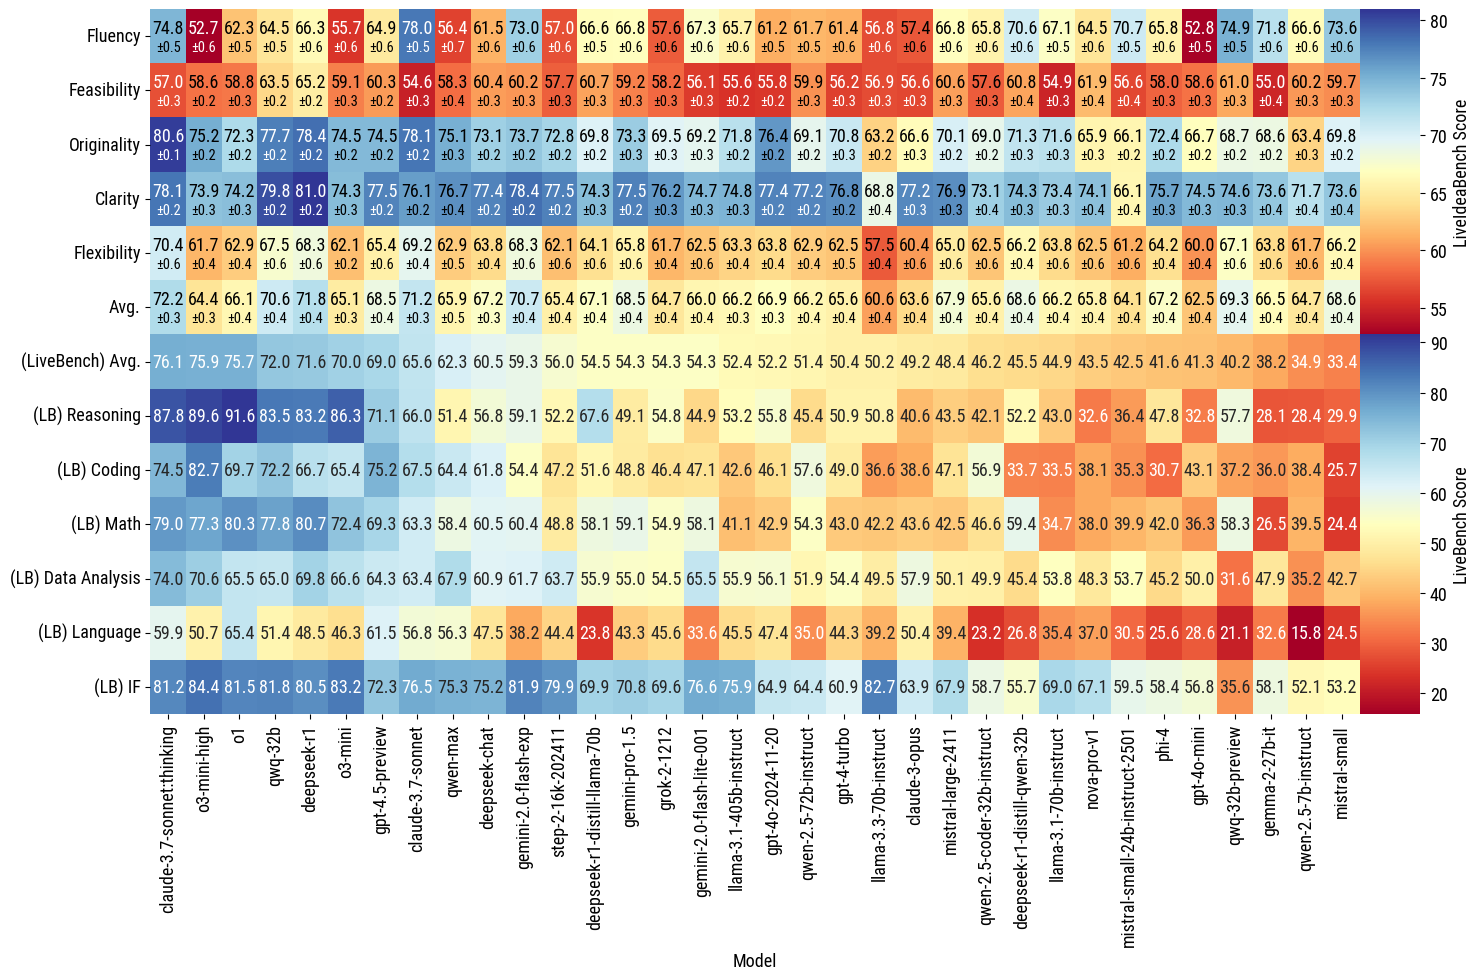

In [ ]:
if is_plot:
    # First, get all the numeric column names
    numeric_columns = df_merge.select_dtypes(include=['int64', 'float64']).columns

    # Add the Model_Short column to the list of columns to keep
    columns_to_keep = list(numeric_columns) + ['Model_Short']

    # Keep only the numeric columns and the Model_Short column
    df_merge = df_merge[columns_to_keep]
    
    # Use regular expressions to filter out columns containing _second or _max
    df_merge = df_merge.loc[:, ~df_merge.columns.str.contains('_second|_max')]
    df_merge = df_merge.set_index('Model_Short', drop=True)
    df_merge.iloc[:, 0:6] *= 10
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    import pandas as pd
    import matplotlib.colors as mcolors

    df_merge.columns = ['Fluency','Feasibility','Originality','Clarity','Flexibility','Avg.','(LiveBench) Avg.','(LB) Reasoning','(LB) Coding','(LB) Math','(LB) Data Analysis','(LB) Language','(LB) IF']

    # Ensure the model order is consistent
    df_merge = df_merge.sort_values(by='(LiveBench) Avg.', ascending=False)
    
    # Create a model name mapping - assuming the index of df_view needs to be transformed by the clean_model_name function
    # If df_view already has an index, use that index to create the mapping
    if not isinstance(df_view.index, pd.RangeIndex):  # Check if df_view has an index
        model_mapping = {name: clean_model_name(name) for name in df_view.index}
    else:  # If df_view uses the default index, assume there is a Model column
        # Find the possible model column names
        possible_model_columns = [col for col in df_view.columns if 'model' in col.lower()]
        if possible_model_columns:
            model_column = possible_model_columns[0]
            model_mapping = {name: clean_model_name(name) for name in df_view[model_column]}
        else:
            raise ValueError("Cannot find a model column in df_view, please specify the model column name")
    
    # Create a reverse mapping, from the cleaned model names back to the original model names
    reverse_mapping = {}
    for orig, cleaned in model_mapping.items():
        if cleaned in df_merge.index:
            reverse_mapping[cleaned] = orig
    
    # Prepare the LiveIdeaBench confidence interval data - we will store tuples (mean_value, ci_value) instead of formatted strings
    ci_data_raw = {}
    
    # Calculate the average error for each model (for the Avg column)
    metrics = ['fluency', 'feasibility', 'originality', 'clarity', 'flexibility']
    avg_symmetric_errors = {}
    
    for view_idx in df_view.index:
        # Collect the error for each dimension
        dimension_errors = []
        
        for metric in metrics:
            # Handle the two possible column name formats
            if metric == 'flexibility':
                mean_col = f"{metric}_mean"
                ci_low_col = f"{metric}_ci_lower"
                ci_high_col = f"{metric}_ci_upper"
            else:
                mean_col = f"{metric}_mean"
                ci_low_col = f"{metric}_ci_low"
                ci_high_col = f"{metric}_ci_high"
            
            # Confirm the columns exist
            if all(col in df_view.columns for col in [mean_col, ci_low_col, ci_high_col]):
                # Get the corresponding values
                mean_val = df_view.loc[view_idx, mean_col]
                ci_low = df_view.loc[view_idx, ci_low_col]
                ci_high = df_view.loc[view_idx, ci_high_col]
                
                # Check if the values are valid
                if not (pd.isna(mean_val) or pd.isna(ci_low) or pd.isna(ci_high)):
                    # Calculate the average error (half of the confidence interval range)
                    error = (ci_high - ci_low) / 2
                    dimension_errors.append(error)
        
        # Calculate the average error across all dimensions
        if dimension_errors:
            avg_error = np.mean(dimension_errors)
            avg_symmetric_errors[view_idx] = avg_error
    
    # Process the individual evaluation metrics
    metrics = [
        ('Fluency', 'fluency_mean', 'fluency_ci_high', 'fluency_ci_low'),
        ('Feasibility', 'feasibility_mean', 'feasibility_ci_high', 'feasibility_ci_low'),
        ('Originality', 'originality_mean', 'originality_ci_high', 'originality_ci_low'),
        ('Clarity', 'clarity_mean', 'clarity_ci_high', 'clarity_ci_low'),
        ('Flexibility', 'flexibility_mean', 'flexibility_ci_upper', 'flexibility_ci_lower')
    ]
    
    # Check if the required columns are present in df_view
    for display_name, mean_col, high_col, low_col in metrics:
        if all(col in df_view.columns for col in [mean_col, high_col, low_col]):
            ci_data_raw[display_name] = []
            for model in df_merge.index:
                if model in reverse_mapping:
                    orig_model = reverse_mapping[model]
                    row = df_view.loc[orig_model]
                    mean_val = row[mean_col] * 10
                    ci_range = (row[high_col] - row[low_col]) / 2 * 10
                    # Store the original values
                    ci_data_raw[display_name].append((mean_val, ci_range))
                else:
                    # If the original model name is not found, use the values from df_merge
                    ci_data_raw[display_name].append((df_merge.loc[model, display_name], None))
    
    # Add the average value column
    ci_data_raw['Avg.'] = []
    if 'average' in df_view.columns:
        for model in df_merge.index:
            if model in reverse_mapping:
                orig_model = reverse_mapping[model]
                mean_val = df_view.loc[orig_model, 'average'] * 10
                
                # Use the average error from avg_symmetric_errors
                if orig_model in avg_symmetric_errors:
                    ci_range = avg_symmetric_errors[orig_model] * 10
                    ci_data_raw['Avg.'].append((mean_val, ci_range))
                else:
                    ci_data_raw['Avg.'].append((mean_val, None))
            else:
                ci_data_raw['Avg.'].append((df_merge.loc[model, 'Avg.'], None))
    else:
        for model in df_merge.index:
            ci_data_raw['Avg.'].append((df_merge.loc[model, 'Avg.'], None))
    
    # Split the dataframe
    liveidea_df = df_merge.iloc[:, 0:6]
    livebench_df = df_merge.iloc[:, 6:]
    
    # Create the figure, using GridSpec to control the layout
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[6, 7], wspace=0.0, hspace=0.0)
    
    # Create the heatmap axes and colorbar axes
    ax_liveidea = plt.subplot(gs[0, 0])
    ax_liveidea_cbar = plt.subplot(gs[0, 1])
    ax_livebench = plt.subplot(gs[1, 0], sharex=ax_liveidea)
    ax_livebench_cbar = plt.subplot(gs[1, 1])
    
    # Define the colormap
    cmap = plt.cm.RdYlBu
    norm = plt.Normalize(vmin=liveidea_df.values.min(), vmax=liveidea_df.values.max())
    
    # Plot the LiveIdeaBench heatmap (without annotations)
    heatmap = sns.heatmap(liveidea_df.T, ax=ax_liveidea, cbar_ax=ax_liveidea_cbar, 
                cmap=cmap, norm=norm, annot=False)
    
    # Create a function to determine the text color
    def get_text_color(value, norm, cmap):
        # Get the color based on the value
        rgba = cmap(norm(value))
        # Calculate the brightness (simplified) - using the weighted average of RGB
        brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        # Use a brightness threshold, typically 0.5 is a good starting point
        return 'white' if brightness < 0.5 else 'black'
    
    # Manually add the annotations with confidence intervals
    for i, metric in enumerate(liveidea_df.columns):
        for j, model in enumerate(liveidea_df.index):
            if metric in ci_data_raw:
                value = liveidea_df.iloc[j, i]
                mean_val, ci_range = ci_data_raw[metric][j]
                text_color = get_text_color(value, norm, cmap)
                
                # Get the base font size
                base_font_size = plt.rcParams['font.size']
                
                # Increase the vertical spacing - move the mean up, the confidence interval down
                # Plot the mean part - use the normal size, move it up more
                ax_liveidea.text(j + 0.5, i + 0.5 - 0.15, f"{mean_val:.1f}", 
                               ha="center", va="center", color=text_color,
                               fontsize=base_font_size)
                
                # Plot the confidence interval part - use a smaller font, move it down more
                if ci_range is not None:
                    ax_liveidea.text(j + 0.5, i + 0.5 + 0.20, f"±{ci_range:.1f}", 
                                   ha="center", va="center", color=text_color,
                                   fontsize=base_font_size * 0.80)  # Reduce the font size to 80%
    
    # Hide the x-axis labels and ticks for the top half
    ax_liveidea.set_xlabel('')
    ax_liveidea.set_xticklabels([])
    
    # Plot the LiveBench heatmap
    sns.heatmap(livebench_df.T, ax=ax_livebench, cbar_ax=ax_livebench_cbar, 
                cmap="RdYlBu", annot=True, fmt='.1f')
    
    # Add colorbar labels
    ax_liveidea_cbar.set_ylabel('LiveIdeaBench Score')
    ax_livebench_cbar.set_ylabel('LiveBench Score')
    
    # Add labels
    ax_livebench.set_xlabel('Model')
    
    # Adjust the layout
    plt.tight_layout()
    plt.savefig('figs/comp_livebench_dual_colormap.pdf')
    plt.show()

In [50]:
df_view.columns

Index(['fluency_mean', 'fluency_std', 'fluency_n', 'fluency_ci_low',
       'fluency_ci_high', 'feasibility_mean', 'feasibility_std',
       'feasibility_n', 'feasibility_ci_low', 'feasibility_ci_high',
       'originality_mean', 'originality_std', 'originality_n',
       'originality_ci_low', 'originality_ci_high', 'clarity_mean',
       'clarity_std', 'clarity_n', 'clarity_ci_low', 'clarity_ci_high',
       'flexibility_mean', 'flexibility_ci_lower', 'flexibility_ci_upper',
       'average'],
      dtype='object')

In [51]:
df_view.columns

Index(['fluency_mean', 'fluency_std', 'fluency_n', 'fluency_ci_low',
       'fluency_ci_high', 'feasibility_mean', 'feasibility_std',
       'feasibility_n', 'feasibility_ci_low', 'feasibility_ci_high',
       'originality_mean', 'originality_std', 'originality_n',
       'originality_ci_low', 'originality_ci_high', 'clarity_mean',
       'clarity_std', 'clarity_n', 'clarity_ci_low', 'clarity_ci_high',
       'flexibility_mean', 'flexibility_ci_lower', 'flexibility_ci_upper',
       'average'],
      dtype='object')

相关系数: 0.35738836079802927, P值: 0.037981212447233736
计算每个模型的平均对称误差...
模型 anthropic/claude-3.7-sonnet:thinking 的平均对称误差: 0.034
模型 deepseek/deepseek-r1 的平均对称误差: 0.037
模型 anthropic/claude-3.7-sonnet 的平均对称误差: 0.032
模型 google/gemini-2.0-flash-exp:free 的平均对称误差: 0.038
模型 qwen/qwq-32b 的平均对称误差: 0.037
模型 google/gemini-2.0-flash-thinking-exp:free 的平均对称误差: 0.038
模型 google/gemini-2.0-pro-exp-02-05:free 的平均对称误差: 0.042
模型 qwen/qwq-32b-preview 的平均对称误差: 0.040
模型 anthropic/claude-3.5-sonnet 的平均对称误差: 0.045
模型 deepseek/deepseek-r1-distill-qwen-32b 的平均对称误差: 0.037
模型 mistralai/mistral-small 的平均对称误差: 0.038
模型 google/gemini-pro-1.5 的平均对称误差: 0.041
模型 openai/gpt-4.5-preview 的平均对称误差: 0.037
模型 mistralai/mistral-large-2411 的平均对称误差: 0.041
模型 deepseek/deepseek-chat 的平均对称误差: 0.034
模型 microsoft/phi-4 的平均对称误差: 0.036
模型 deepseek/deepseek-r1-distill-llama-70b 的平均对称误差: 0.040
模型 openai/gpt-4o-2024-11-20 的平均对称误差: 0.033
模型 openai/o1-mini 的平均对称误差: 0.036
模型 google/gemma-2-27b-it 的平均对称误差: 0.044
模型 sammcj/qwen2.5-dracarys2-72b:Q4_

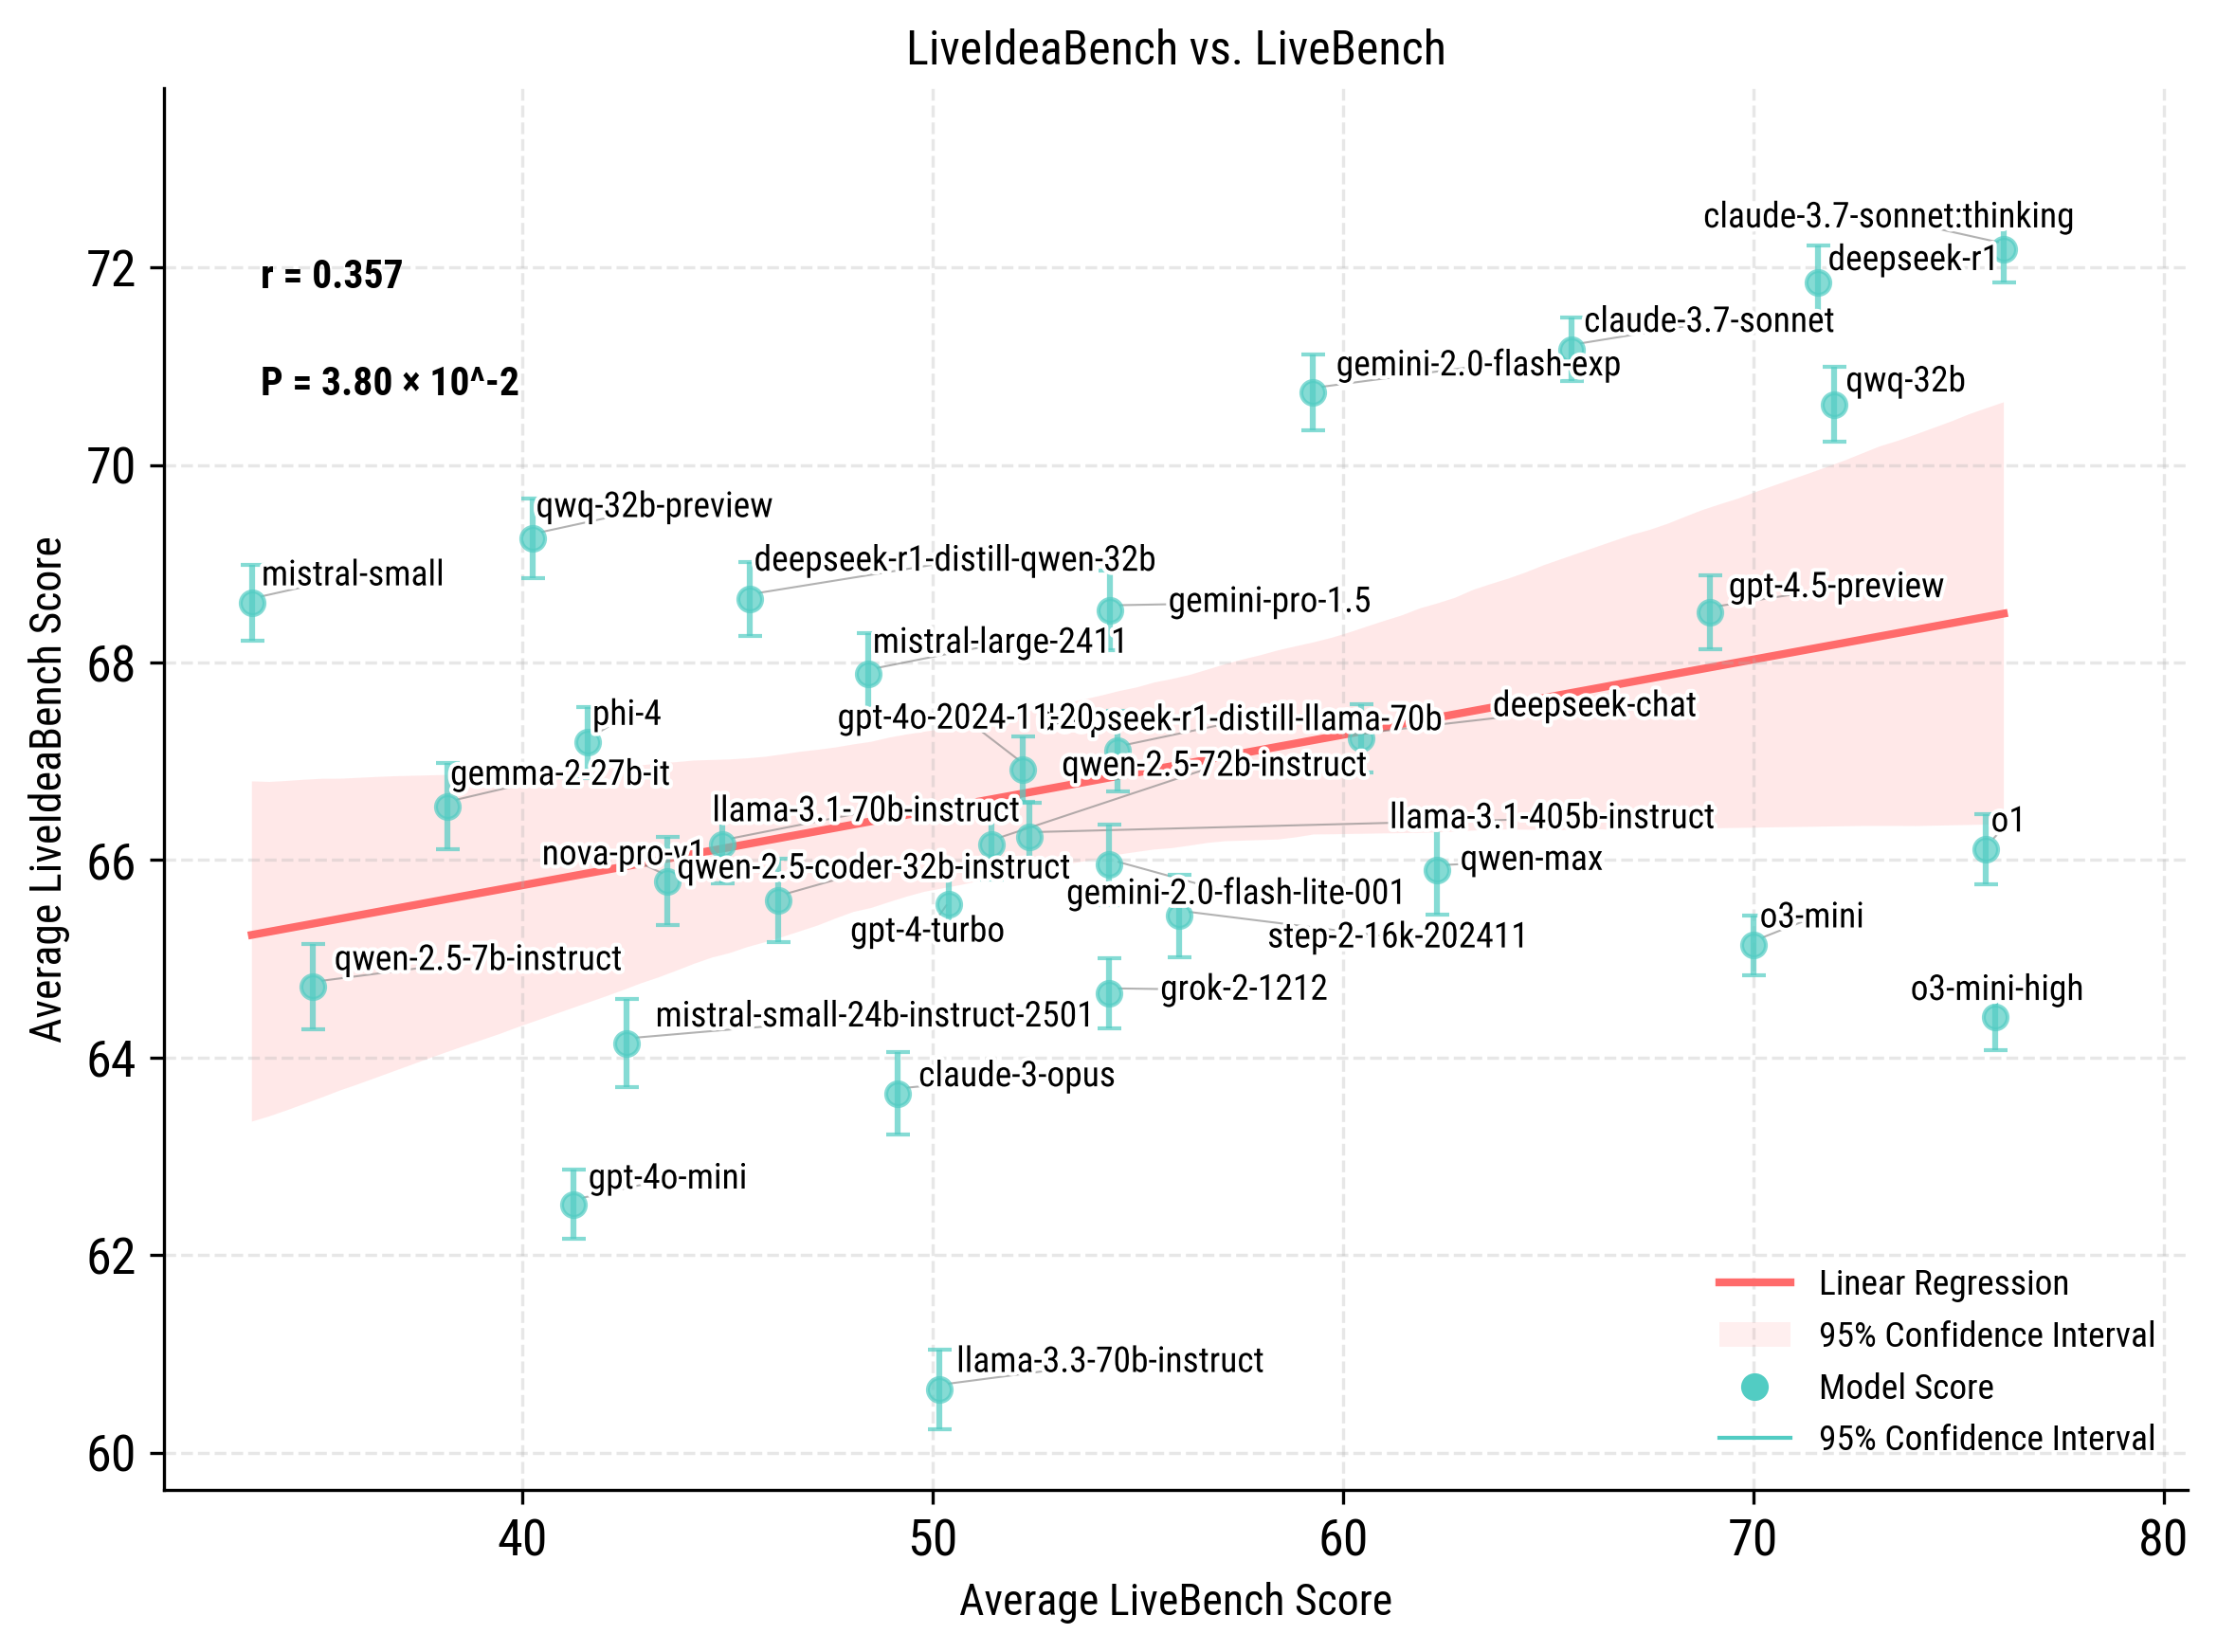

图表已成功保存到 figs/reg_livebench.pdf
绘图过程成功完成！


In [ ]:
def plot_regression_with_ci(df_merge, df_view, save_path='figs/reg_livebench.pdf'):
    """
    Plot a regression plot with symmetric error bars, displaying the correlation between LiveBench and LiveIdeaBench.
    The style follows academic journal standards, with all statistical values displayed using 3 significant digits, and p-values always shown in scientific notation.
    
    Parameters:
    df_merge: A DataFrame containing the results of the two benchmark tests.
    df_view: A DataFrame containing the computed confidence interval results.
    save_path: The path to save the figure.
    """
    import scipy.stats as stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patheffects as pe
    from adjustText import adjust_text
    from matplotlib.lines import Line2D
    
    # Calculate the correlation coefficient and p-value
    correlation, p_value = stats.pearsonr(df_merge['(LiveBench) Avg.'], df_merge['Avg.'])
    print(f"Correlation coefficient: {correlation}, P-value: {p_value}")
    
    # Create the figure
    fig = plt.figure(figsize=(8, 6), dpi=300)
    ax = fig.add_subplot(111)
    
    # Calculate the average symmetric error for each model
    print("Calculating the average symmetric error for each model...")
    
    metrics = ['fluency', 'feasibility', 'originality', 'clarity', 'flexibility']
    avg_symmetric_errors = {}
    
    for view_idx in df_view.index:
        # Collect the errors for each dimension
        dimension_errors = []
        
        for metric in metrics:
            # Handle the two possible column name formats
            if metric == 'flexibility':
                mean_col = f"{metric}_mean"
                ci_low_col = f"{metric}_ci_lower"
                ci_high_col = f"{metric}_ci_upper"
            else:
                mean_col = f"{metric}_mean"
                ci_low_col = f"{metric}_ci_low"
                ci_high_col = f"{metric}_ci_high"
            
            # Confirm the columns exist
            if all(col in df_view.columns for col in [mean_col, ci_low_col, ci_high_col]):
                # Get the corresponding values
                mean_val = df_view.loc[view_idx, mean_col]
                ci_low = df_view.loc[view_idx, ci_low_col]
                ci_high = df_view.loc[view_idx, ci_high_col]
                
                # Check if the values are valid
                if not (pd.isna(mean_val) or pd.isna(ci_low) or pd.isna(ci_high)):
                    # Calculate the average error (half the confidence interval range)
                    error = (ci_high - ci_low) / 2
                    dimension_errors.append(error)
        
        # Calculate the average error across all dimensions
        if dimension_errors:
            avg_error = np.mean(dimension_errors)
            avg_symmetric_errors[view_idx] = avg_error
            print(f"The average symmetric error for model {view_idx} is: {avg_error:.3f}")
        else:
            print(f"Warning: Unable to calculate the symmetric error for model {view_idx}, as there is not enough dimension data.")
    
    # Create a model index mapping
    print("Creating a model index mapping...")
    index_mapping = {}
    
    # Clean the model names in both DataFrames
    df_view_cleaned_names = {clean_model_name(idx).lower(): idx for idx in df_view.index}
    df_merge_cleaned_names = {clean_model_name(idx).lower(): idx for idx in df_merge.index}
    
    # Find exact matches
    for view_name, original_view_idx in df_view_cleaned_names.items():
        if view_name in df_merge_cleaned_names:
            original_merge_idx = df_merge_cleaned_names[view_name]
            index_mapping[original_view_idx] = original_merge_idx
            print(f"Exact match: {original_view_idx} -> {original_merge_idx}")
    
    # If there are not enough exact matches, try partial matches
    if len(index_mapping) < min(5, len(df_view.index)):
        print("Trying partial matches...")
        for view_idx in df_view.index:
            if view_idx not in [k for k in index_mapping.keys()]:
                view_name = clean_model_name(view_idx).lower()
                
                # Look for containment relationships
                for merge_idx in df_merge.index:
                    merge_name = clean_model_name(merge_idx).lower()
                    if view_name in merge_name or merge_name in view_name:
                        index_mapping[view_idx] = merge_idx
                        print(f"Partial match: {view_idx} -> {merge_idx}")
                        break
    
    # Set the plot style
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Plot the regression line - also plot the 95% confidence interval band
    print("Plotting the regression line and confidence interval...")
    sns.regplot(data=df_merge, 
                x='(LiveBench) Avg.', 
                y='Avg.',
                scatter_kws={'alpha':0},  # Do not show the original points
                line_kws={'color': '#ff6b6b', 'zorder': 1, 'linewidth': 2},
                ci=95,  # Add the 95% confidence interval
                ax=ax)
    
    # Plot the scatter points with symmetric error bars
    print("Plotting the scatter points and error bars...")
    points_with_error = 0
    
    # First, plot all the points
    points = []  # Store the point coordinates
    point_objects = []  # Store the scatter point objects
    confidence_level = 95  # The confidence interval level, usually 95%
    
    for view_idx, merge_idx in index_mapping.items():
        try:
            x = df_merge.loc[merge_idx, '(LiveBench) Avg.']
            y = df_merge.loc[merge_idx, 'Avg.']
            points.append((x, y))
            
            # If there is a calculated symmetric error, use it
            if view_idx in avg_symmetric_errors:
                # Get the average symmetric error and convert it to a 0-100 scale
                symmetric_error = avg_symmetric_errors[view_idx] * 10
                
                # Use the same color as the example code
                error_bar = ax.errorbar(x, y, yerr=symmetric_error, fmt='o', color='#52ccc3', 
                            alpha=0.7, capsize=3, ecolor='#52ccc3', zorder=5,
                            markersize=6)
                point_objects.append(error_bar)
                
                print(f"Plotted a point for model {merge_idx} with symmetric error bars: x={x:.2f}, y={y:.2f}, "
                     f"error range: [{y-symmetric_error:.2f}, {y+symmetric_error:.2f}]")
                
                points_with_error += 1
            else:
                # If there is no error data, still plot the point, but record a warning
                point = ax.scatter(x, y, color='#52ccc3', alpha=0.7, zorder=5, s=36)
                point_objects.append(point)
                print(f"Warning: Model {merge_idx} has no error data, only plotting the point")
            
        except Exception as e:
            print(f"Error plotting model {merge_idx}: {e}")
    
    # Prepare the text labels
    print("Preparing the text labels...")
    texts = []
    labels = []
    
    # First, try to place all the labels in the top right corner
    for i, (view_idx, merge_idx) in enumerate(index_mapping.items()):
        try:
            if i < len(points):
                x, y = points[i]
                clean_label = clean_model_name(merge_idx)
                labels.append(clean_label)
                
                # Create the text object, default position is to the top right of the point
                text = ax.text(x + 0.05, y + 0.05, clean_label, fontsize=9, 
                              ha='left', va='bottom', zorder=10,
                              path_effects=[pe.withStroke(linewidth=2, foreground='white')])
                texts.append(text)
        except Exception as e:
            print(f"Error adding a label for model {merge_idx}: {e}")
    
    # Use adjust_text to detect and resolve overlapping labels
    print("Checking for label overlaps and adjusting as needed...")
    
    adjust_text(texts, 
               arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6, zorder=2),
               expand_points=(1.2, 1.2),
               force_points=(0.5, 0.5),
               force_text=(0.5, 0.5),
               only_move={'points':'xy', 'texts':'xy'},
               add_objects=point_objects,
               autoalign=False,
               lim=5,
               text_from_points=False,
               avoid_self=True,
               save_steps=False,
               avoid_points=True,
               ax=ax)
    
    # Add the title and axis labels
    ax.set_title('LiveIdeaBench vs. LiveBench', fontsize=12)
    ax.set_xlabel('Average LiveBench Score', fontsize=11)
    ax.set_ylabel('Average LiveIdeaBench Score', fontsize=11)
    
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Calculate the position for the statistical metrics text - in the top left corner
    text_x = x_min + (x_max - x_min) * 0.05  # Left side position
    text_y_r = y_max - (y_max - y_min) * 0.1  # Top position
    text_y_p = y_max - (y_max - y_min) * 0.18  # Slightly lower position
    
    # Academic journal style: Format the statistical values precisely, using 3 significant digits and scientific notation
    
    # Correlation coefficient with 3 significant digits
    r_formatted = f"{correlation:.3g}"
    if 'e' not in r_formatted and len(r_formatted) < 5 and float(r_formatted) != 0:
        # If not using scientific notation and less than 5 digits (including decimal and sign), ensure 3 significant digits
        r_formatted = f"{correlation:.3g}"
        # If fewer than 3 decimal places, pad with zeros
        if '.' in r_formatted:
            integer_part, decimal_part = r_formatted.split('.')
            if len(decimal_part) < 3 and float(r_formatted) != int(float(r_formatted)):
                r_formatted = f"{float(r_formatted):.3f}"
    
    # P-value in the correct scientific notation format: n.nn × 10^-xx
    if p_value == 0:
        p_formatted = "P < 0.001"
    else:
        magnitude = int(np.floor(np.log10(abs(p_value))))
        mantissa = p_value / (10 ** magnitude)
        p_formatted = f"{mantissa:.2f} × 10^{magnitude}"
        
    ax.text(text_x, text_y_r, f"r = {r_formatted}", fontsize=10, fontweight='bold')
    ax.text(text_x, text_y_p, f"P = {p_formatted}", fontsize=10, fontweight='bold')
    
    # Create a professional-looking legend
    custom_lines = [
        Line2D([0], [0], color='#ff6b6b', lw=2),
        plt.Rectangle((0, 0), 1, 1, fc='#ff6b6b', alpha=0.1),
        Line2D([0], [0], marker='o', color='#52ccc3', markersize=6, lw=0),
        Line2D([0], [0], color='#52ccc3', lw=1)
    ]
    
    legend_labels = [
        'Linear Regression',
        f'95% Confidence Interval',
        'Model Score',
        f'{confidence_level}% Confidence Interval'
    ]
    
    # Place the legend in the bottom right corner
    ax.legend(custom_lines, legend_labels, 
             loc='lower right', 
             frameon=True,
             framealpha=0, # Transparent background
             fontsize=9)
    
    # Adjust the axis limits to ensure there is enough space for the text
    ax.set_xlim(x_min, x_max + (x_max - x_min) * 0.05)
    ax.set_ylim(y_min, y_max + (y_max - y_min) * 0.05)
    
    fig.tight_layout()
    
    # Save the figure
    plt.savefig(save_path)
    plt.show()
    print(f"The figure has been successfully saved to {save_path}")
    return True  # Indicate successful completion

if is_plot:
    try:
        success = plot_regression_with_ci(df_merge, df_view)
        if success:
            print("The plotting process completed successfully!")
    except Exception as e:
        print(f"Plotting failed: {e}")
        raise

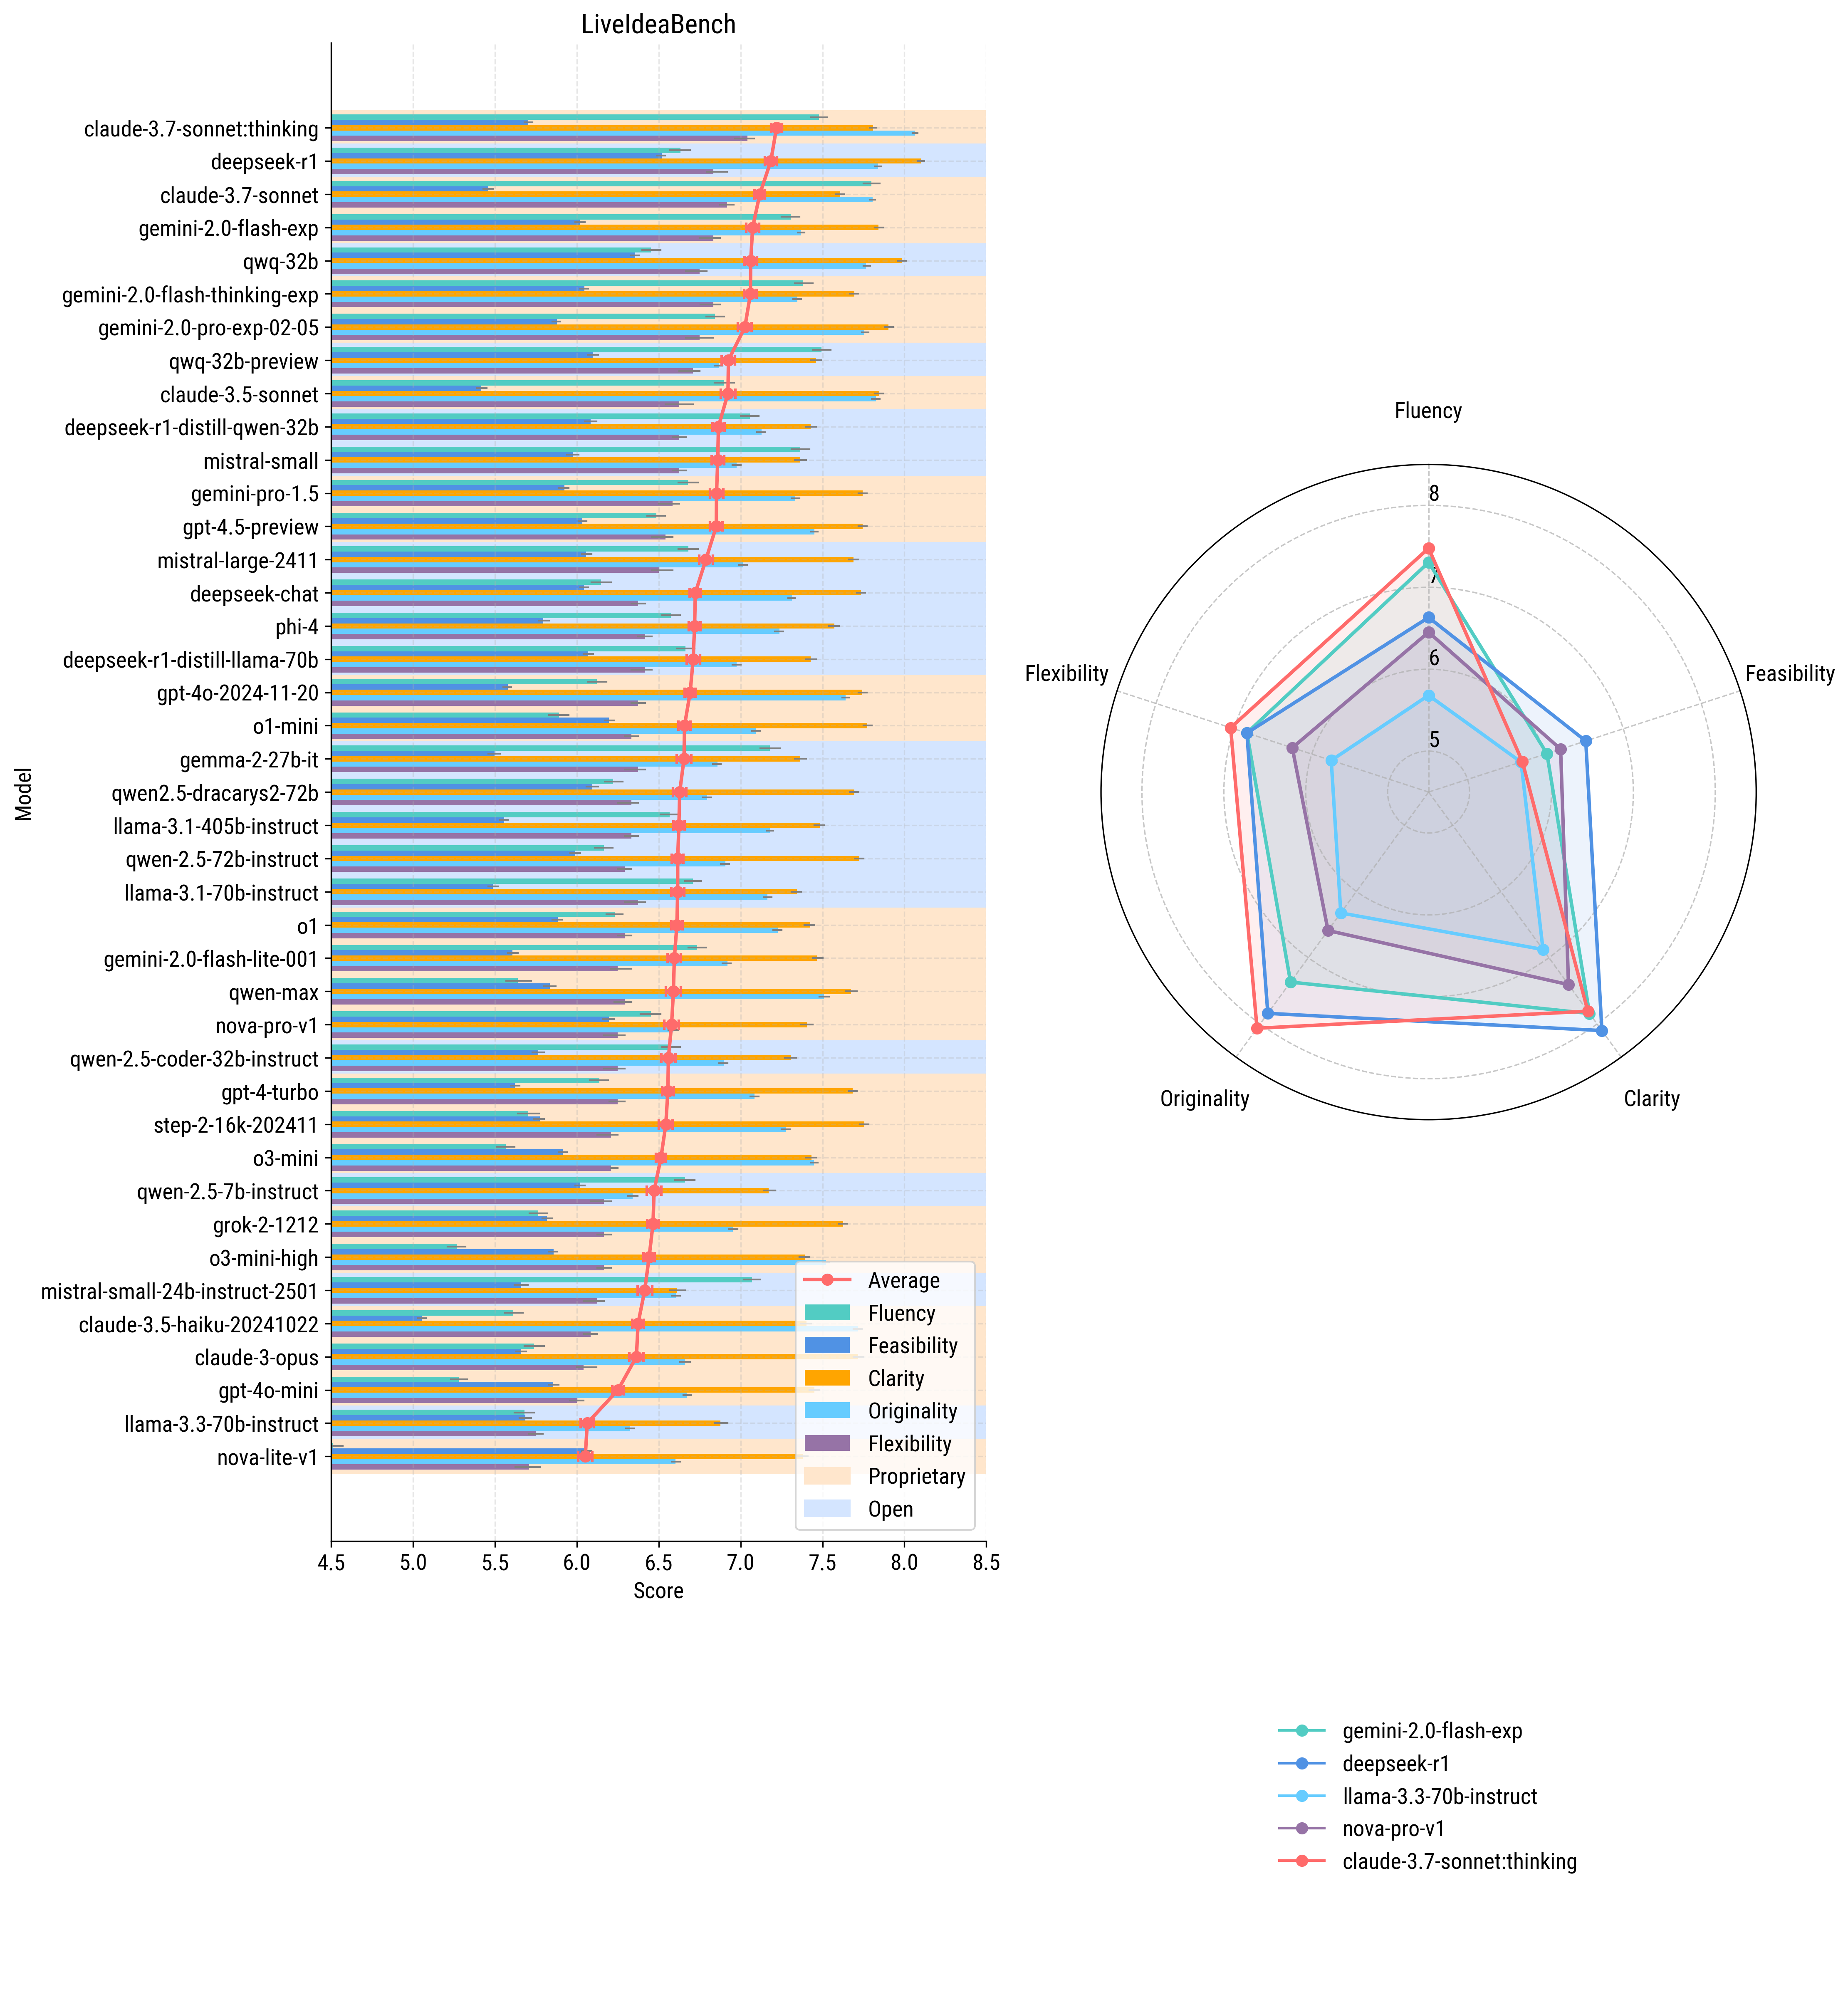

带置信区间的表格已保存到./tex/liveideabench_table_with_ci.tex


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Assume df_latex and df_view are predefined DataFrames
# Example DataFrame structures (replace with your actual data)
data_latex = {
    'Model_Short': [f'Model_{i}' for i in range(1, 41)],
    'Fluency': np.random.uniform(5, 8, 40),
    'Feasibility': np.random.uniform(5, 8, 40),
    'Clarity': np.random.uniform(5, 8, 40),
    'Originality': np.random.uniform(5, 8, 40),
    'Flexibility': np.random.uniform(5, 8, 40),
    'Is_Open_Source': np.random.choice([True, False], 40),
}
data_latex['Average'] = np.mean([data_latex['Fluency'], data_latex['Feasibility'], data_latex['Clarity'], data_latex['Originality'], data_latex['Flexibility']], axis=0)
df_latex = pd.DataFrame(data_latex)

data_view = {
    'fluency_ci_low': df_latex['Fluency'] - np.random.uniform(0.1, 0.3, 40),
    'fluency_ci_high': df_latex['Fluency'] + np.random.uniform(0.1, 0.3, 40),
    'feasibility_ci_low': df_latex['Feasibility'] - np.random.uniform(0.1, 0.3, 40),
    'feasibility_ci_high': df_latex['Feasibility'] + np.random.uniform(0.1, 0.3, 40),
    'clarity_ci_low': df_latex['Clarity'] - np.random.uniform(0.1, 0.3, 40),
    'clarity_ci_high': df_latex['Clarity'] + np.random.uniform(0.1, 0.3, 40),
    'originality_ci_low': df_latex['Originality'] - np.random.uniform(0.1, 0.3, 40),
    'originality_ci_high': df_latex['Originality'] + np.random.uniform(0.1, 0.3, 40),
    'flexibility_ci_lower': df_latex['Flexibility'] - np.random.uniform(0.1, 0.3, 40),
    'flexibility_ci_upper': df_latex['Flexibility'] + np.random.uniform(0.1, 0.3, 40),
}
df_view = pd.DataFrame(data_view)

# Sort df_latex by Average score descending for plotting order
df_latex = df_latex.sort_values(by='Average', ascending=False).reset_index(drop=True)
# Realign df_view based on the new sorted order of df_latex
# (Assuming original alignment was based on some index not shown, we reset both)
df_view_aligned = df_view.reindex(df_latex.index).reset_index(drop=True) # Make sure df_view aligns with the sorted df_latex

is_plot = True # Set to True to generate plot and table

if is_plot:
    # Create figure and layout
    fig = plt.figure(figsize=(15, 20), dpi=300)  # Increase height to accommodate the bottom legend
    gs = GridSpec(2, 2, height_ratios=[4, 1])  # 2 rows, 2 columns, top large, bottom small

    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])  # Left plot
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')  # Right plot (polar for radar)

    # Sample 5 models for the radar chart
    total_models = len(df_latex)
    # sample_indices = [1-1, 2-1, 20-1, 8-1, 4-1]  # Manually specify models for the radar plot (example)
    sample_indices = [4-1, 2-1, 40-1, 28-1, 1-1]  # Manually specify models for the radar plot (using 0-based index)
    # Adjust indices if they are out of bounds after sorting
    sample_indices = [idx for idx in sample_indices if idx < total_models]
    if len(sample_indices) < 5:
        print(f"Warning: Only {len(sample_indices)} models available for radar plot based on indices.")
        # Optionally, take the top N models if indices are invalid
        # sample_indices = list(range(min(5, total_models)))

    sampled_models = df_latex.iloc[sample_indices]

    # === Left Plot (Bar Chart) ===
    width = 0.16  # Reduce width to accommodate 5 bars
    y = np.arange(len(df_latex['Model_Short'])) # y-coordinates for the horizontal bars

    # Add background color based on Open Source status
    for idx, is_open in enumerate(df_latex['Is_Open_Source']):
        color = '#d4e5ff' if is_open else '#ffe6cc' # Blue for Open, Orange for Proprietary
        ax1.axhspan(idx - 0.5, idx + 0.5, color=color, alpha=1.0, zorder=0) # zorder=0 to keep background behind bars

    # Keep df_latex and df_view_aligned aligned
    # df_view_aligned = df_view.reset_index(drop=True) # Already aligned above after sorting df_latex

    # Plot bar chart, add Clarity dimension
    ax1.barh(y - 2*width, df_latex['Fluency'], width, label='Fluency', color='#52ccc3')
    ax1.barh(y - width, df_latex['Feasibility'], width, label='Feasibility', color='#5092e4')
    ax1.barh(y, df_latex['Clarity'], width, label='Clarity', color='#ffa500')  # Added Clarity, using orange color
    ax1.barh(y + width, df_latex['Originality'], width, label='Originality', color='#66ccff')
    ax1.barh(y + 2*width, df_latex['Flexibility'], width, label='Flexibility', color='#9673a6')

    # Manually add simple gray error bars (confidence intervals)
    for i in range(len(df_latex)):
        # Fluency error bar
        ax1.plot([df_view_aligned.iloc[i]['fluency_ci_low'], df_view_aligned.iloc[i]['fluency_ci_high']],
                 [y[i] - 2*width, y[i] - 2*width], color='grey', alpha=1.0, linewidth=1.0)

        # Feasibility error bar
        ax1.plot([df_view_aligned.iloc[i]['feasibility_ci_low'], df_view_aligned.iloc[i]['feasibility_ci_high']],
                 [y[i] - width, y[i] - width], color='grey', alpha=1.0, linewidth=1.0)

        # Clarity error bar
        ax1.plot([df_view_aligned.iloc[i]['clarity_ci_low'], df_view_aligned.iloc[i]['clarity_ci_high']],
                 [y[i], y[i]], color='grey', alpha=1.0, linewidth=1.0)

        # Originality error bar
        ax1.plot([df_view_aligned.iloc[i]['originality_ci_low'], df_view_aligned.iloc[i]['originality_ci_high']],
                 [y[i] + width, y[i] + width], color='grey', alpha=1.0, linewidth=1.0)

        # Flexibility error bar
        ax1.plot([df_view_aligned.iloc[i]['flexibility_ci_lower'], df_view_aligned.iloc[i]['flexibility_ci_upper']],
                 [y[i] + 2*width, y[i] + 2*width], color='grey', alpha=1.0, linewidth=1.0)

    # Plot the average line
    ax1.plot(df_latex['Average'], y, color='#ff6b6b', marker='o', markersize=4, linewidth=2, label='Average', zorder=5)

    # Add confidence intervals for the average - horizontally symmetric
    for i in range(len(df_latex)):
        # Calculate the width of confidence intervals for all dimensions
        ci_widths = [
            df_view_aligned.iloc[i]['fluency_ci_high'] - df_view_aligned.iloc[i]['fluency_ci_low'],
            df_view_aligned.iloc[i]['feasibility_ci_high'] - df_view_aligned.iloc[i]['feasibility_ci_low'],
            df_view_aligned.iloc[i]['clarity_ci_high'] - df_view_aligned.iloc[i]['clarity_ci_low'],
            df_view_aligned.iloc[i]['originality_ci_high'] - df_view_aligned.iloc[i]['originality_ci_low'],
            df_view_aligned.iloc[i]['flexibility_ci_upper'] - df_view_aligned.iloc[i]['flexibility_ci_lower']
        ]

        # Calculate the average CI width and divide by 2 to get the half-width (making it symmetric)
        avg_ci_half_width = np.mean(ci_widths) / 2

        # Get the average value of the current model
        avg_value = df_latex.iloc[i]['Average']

        # Plot horizontal error bars - red I-beam shape, symmetric error bars for the Average
        ax1.errorbar(
            avg_value,
            y[i],
            xerr=avg_ci_half_width,  # Symmetric error, only need a single value
            fmt='none',              # Do not draw the point again, just the error bar
            ecolor='#ff6b6b',        # Error bar color matches the average line
            capsize=3,               # Size of the end caps
            capthick=1.5,            # Thickness of the caps
            elinewidth=1.5,          # Thickness of the error bar line
            zorder=10                # Ensure it's drawn on top
        )

    # Create legend patches for background colors
    proprietary_patch = mpatches.Patch(color='#ffe6cc', label='Proprietary')
    opensource_patch = mpatches.Patch(color='#d4e5ff', label='Open')

    # Combine all legend elements (bars and background patches)
    handles, labels = ax1.get_legend_handles_labels()
    # Ensure Average is last visually if desired, or sort handles/labels
    # handles.sort(key=lambda h: labels[handles.index(h)] != 'Average') # Example sort
    # labels.sort(key=lambda l: l != 'Average')
    handles.extend([proprietary_patch, opensource_patch])
    # labels.extend(['Proprietary', 'Open']) # Labels are taken from the patches directly

    # Customize the left plot
    ax1.set_yticks(y)
    ax1.set_yticklabels(df_latex['Model_Short'])
    ax1.set_ylabel('Model')
    ax1.set_xlabel('Score')
    ax1.set_title('LiveIdeaBench Evaluation') # Changed title slightly
    # Place legend outside the plot area
    # ax1.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Alternative placement
    ax1.legend(handles=handles, loc='lower right', bbox_to_anchor=(1.0, 0.0)) # Original placement attempt
    ax1.grid(True, axis='x', alpha=0.3, linestyle='--') # Grid lines only on x-axis
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.invert_yaxis()  # Display models from highest score (top) to lowest (bottom)
    ax1.set_xlim(4.5, 8.5) # Set x-axis limits

    # === Right Plot (Radar Chart) ===
    # Set categories (dimensions) for the radar chart, including Clarity
    categories = ['Fluency', 'Feasibility', 'Clarity', 'Originality', 'Flexibility']
    num_vars = len(categories)
    # Calculate angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the shape

    # Configure the radar chart appearance
    ax2.set_theta_offset(np.pi / 2) # Rotate plot to start at the top
    ax2.set_theta_direction(-1) # Plot axes clockwise

    # Draw grid lines and labels
    ax2.set_rlabel_position(0) # Position radial labels near the center
    ax2.set_rticks([5, 6, 7, 8]) # Set radial ticks (score values)
    ax2.set_rlim(4.5, 8.5) # Set radial limits (score range)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Set angle ticks and labels (categories)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories)
    # Increase the distance between labels (categories) and the plot edge
    ax2.xaxis.set_tick_params(pad=20)  # Adjust padding as needed

    # Define color list for the radar plot lines
    colors = ['#52ccc3', '#5092e4', '#ff6b6b', '#9673a6', '#ffa500'] # Example colors, adjust as needed

    # Plot data for each sampled model, including Clarity
    for idx, (model_idx, model) in enumerate(sampled_models.iterrows()):
        values = [model['Fluency'], model['Feasibility'],
                  model['Clarity'], model['Originality'], model['Flexibility']]  # Include Clarity
        values += values[:1] # Close the shape by repeating the first value
        actual_color = colors[idx % len(colors)] # Cycle through colors if more models than colors
        ax2.plot(angles, values, 'o-', linewidth=2, label=model['Model_Short'], color=actual_color)
        ax2.fill(angles, values, alpha=0.1, color=actual_color)

    # Create a separate legend for the radar chart in the bottom subplot area
    legend_ax = fig.add_subplot(gs[1, 1]) # Use the bottom-right grid cell for the legend
    legend_ax.axis('off') # Hide axes for the legend subplot
    legend_elements = []
    # Ensure legend uses the same colors as the plot
    for idx, (model_idx, model) in enumerate(sampled_models.iterrows()):
        actual_color = colors[idx % len(colors)]
        legend_elements.append(Line2D([0], [0], color=actual_color,
                                     label=model['Model_Short'],
                                     marker='o', linestyle='-'))
    legend_ax.legend(handles=legend_elements,
                     loc='center', # Center the legend within its subplot area
                     ncol=1,       # Arrange legend items vertically
                     frameon=False) # No frame around the legend

    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout, leave space at bottom
    # plt.subplots_adjust(bottom=0.15) # Adjust bottom spacing explicitly if tight_layout isn't enough
    # Ensure the 'figs' directory exists or change the path
    # import os
    # if not os.path.exists('figs'): os.makedirs('figs')
    plt.savefig('figs/radar_combined.pdf', bbox_inches='tight') # Save the figure
    plt.show() # Display the figure


    # === LaTeX Table Generation ===
    # Determine the indices of the top and second-highest scoring models for each column
    columns = ['Fluency', 'Feasibility', 'Clarity', 'Originality', 'Flexibility', 'Average']
    top_indices = {}
    second_indices = {}

    for col in columns:
        # Get sorted indices (descending)
        sorted_values = df_latex[col].sort_values(ascending=False)
        top_model_idx = sorted_values.index[0]
        second_model_idx = sorted_values.index[1] # Assumes at least 2 models exist

        # Store row position information (iloc index)
        top_indices[col] = df_latex.index.get_loc(top_model_idx)
        second_indices[col] = df_latex.index.get_loc(second_model_idx)

    # LaTeX table version with confidence intervals
    latex_table_with_ci = "\\begin{table*}[ht]\n" # Use table* for full width
    latex_table_with_ci += "\\centering\n"
    latex_table_with_ci += "\\caption{Evaluation scores on \\texttt{LiveIdeaBench} with 95\\% confidence intervals. Best scores are bolded (\\textbf{bold}), second best are underlined (\\underline{underline}).}\n" # More descriptive caption
    latex_table_with_ci += "\\label{tab:liveideabench_scores_with_ci}\n"
    latex_table_with_ci += "\\resizebox{\\textwidth}{!}{\n" # Scale table to text width
    # Adjusted column types for better alignment and monospace font
    latex_table_with_ci += "\\begin{tabular}{>{\\ttfamily}l|c|*{6}{c}}\n" # Use 'c' for centered scores
    latex_table_with_ci += "\\toprule\n"
    latex_table_with_ci += "\\textbf{Model} & \\textbf{Open} & \\textbf{Fluency} & \\textbf{Feasibility} & \\textbf{Clarity} & \\textbf{Originality} & \\textbf{Flexibility} & \\textbf{Average} \\\\\n"
    latex_table_with_ci += "\\midrule\n"

    # Add data rows for each model, including confidence intervals
    for i in range(len(df_latex)):
        row = df_latex.iloc[i]
        df_view_row = df_view_aligned.iloc[i]
        open_source = "\\checkmark" if row['Is_Open_Source'] else "" # Checkmark for Open Source

        # Scores and their confidence intervals for each dimension - using correct LaTeX math syntax
        fluency_ci = f"{row['Fluency']:.2f}_{{{df_view_row['fluency_ci_low']:.2f}}}^{{{df_view_row['fluency_ci_high']:.2f}}}"
        feasibility_ci = f"{row['Feasibility']:.2f}_{{{df_view_row['feasibility_ci_low']:.2f}}}^{{{df_view_row['feasibility_ci_high']:.2f}}}"
        clarity_ci = f"{row['Clarity']:.2f}_{{{df_view_row['clarity_ci_low']:.2f}}}^{{{df_view_row['clarity_ci_high']:.2f}}}"
        originality_ci = f"{row['Originality']:.2f}_{{{df_view_row['originality_ci_low']:.2f}}}^{{{df_view_row['originality_ci_high']:.2f}}}"
        flexibility_ci = f"{row['Flexibility']:.2f}_{{{df_view_row['flexibility_ci_lower']:.2f}}}^{{{df_view_row['flexibility_ci_upper']:.2f}}}"

        # Confidence interval for the average score (using the average width of CIs from each dimension)
        ci_widths = [
            df_view_row['fluency_ci_high'] - df_view_row['fluency_ci_low'],
            df_view_row['feasibility_ci_high'] - df_view_row['feasibility_ci_low'],
            df_view_row['clarity_ci_high'] - df_view_row['clarity_ci_low'],
            df_view_row['originality_ci_high'] - df_view_row['originality_ci_low'],
            df_view_row['flexibility_ci_upper'] - df_view_row['flexibility_ci_lower']
        ]
        avg_ci_half_width = np.mean(ci_widths) / 2
        avg_ci_low = row['Average'] - avg_ci_half_width
        avg_ci_high = row['Average'] + avg_ci_half_width
        # Ensure CI bounds do not cross reasonable limits if needed (e.g., max score)
        average_ci = f"{row['Average']:.2f}_{{{avg_ci_low:.2f}}}^{{{avg_ci_high:.2f}}}"

        # Use bold and underline commands suitable for math mode
        # Apply bold formatting to the highest score, using \boldsymbol
        if i == top_indices['Fluency']: fluency_ci = f"\\boldsymbol{{{fluency_ci}}}"
        if i == top_indices['Feasibility']: feasibility_ci = f"\\boldsymbol{{{feasibility_ci}}}"
        if i == top_indices['Clarity']: clarity_ci = f"\\boldsymbol{{{clarity_ci}}}"
        if i == top_indices['Originality']: originality_ci = f"\\boldsymbol{{{originality_ci}}}"
        if i == top_indices['Flexibility']: flexibility_ci = f"\\boldsymbol{{{flexibility_ci}}}"
        if i == top_indices['Average']: average_ci = f"\\boldsymbol{{{average_ci}}}"

        # Apply underline formatting to the second-highest score, using \underline in math mode
        # Important: Nesting \boldsymbol and \underline might need care depending on LaTeX setup
        # Check if the current index is second highest *and not* also the highest (can happen with ties)
        if i == second_indices['Fluency'] and i != top_indices['Fluency']: fluency_ci = f"\\underline{{{fluency_ci}}}"
        if i == second_indices['Feasibility'] and i != top_indices['Feasibility']: feasibility_ci = f"\\underline{{{feasibility_ci}}}"
        if i == second_indices['Clarity'] and i != top_indices['Clarity']: clarity_ci = f"\\underline{{{clarity_ci}}}"
        if i == second_indices['Originality'] and i != top_indices['Originality']: originality_ci = f"\\underline{{{originality_ci}}}"
        if i == second_indices['Flexibility'] and i != top_indices['Flexibility']: flexibility_ci = f"\\underline{{{flexibility_ci}}}"
        if i == second_indices['Average'] and i != top_indices['Average']: average_ci = f"\\underline{{{average_ci}}}"

        # Format the row for LaTeX, ensuring math mode ($...$) around scores with CIs
        latex_table_with_ci += f"{row['Model_Short']} & {open_source} & "
        latex_table_with_ci += f"${fluency_ci}$ & ${feasibility_ci}$ & ${clarity_ci}$ & "
        latex_table_with_ci += f"${originality_ci}$ & ${flexibility_ci}$ & ${average_ci}$ \\\\\n"

    latex_table_with_ci += "\\bottomrule\n"
    latex_table_with_ci += "\\end{tabular}\n"
    latex_table_with_ci += "}\n" # End resizebox
    latex_table_with_ci += "\\end{table*}\n" # End table*

    # Write to file
    # Ensure the 'tex' directory exists or change the path
    # import os
    # if not os.path.exists('tex'): os.makedirs('tex')
    output_tex_file = './tex/liveideabench_table_with_ci.tex'
    with open(output_tex_file, 'w') as f:
        f.write(latex_table_with_ci)
    print(f"LaTeX table with confidence intervals saved to {output_tex_file}")

In [ ]:
# Check if plotting/table generation is enabled
if is_plot:

    # Function to format a value for the LaTeX table
    # Highlights the maximum value in bold and the second maximum value underlined
    def format_value(value, col_max, col_second):
        # If the value is the maximum in the column (within tolerance)
        if abs(value - col_max) < 1e-6:
            # Format as bold
            return f"\\textbf{{{value:.2f}}}"
        # If the value is the second maximum in the column (within tolerance)
        elif abs(value - col_second) < 1e-6:
            # Format as underlined
            return f"\\underline{{{value:.2f}}}"
        # Otherwise, just format to two decimal places
        return f"{value:.2f}"

    # Function to format the model name (currently not used in the active code path below)
    def capitalize_model_name(name):
        # Extract the last part of the model name (after the last '/')
        model_name = name.split('/')[-1]
        # Special handling for certain prefixes
        for prefix in ['gpt', 'llama']:
            if model_name.startswith(prefix):
                # Convert specific prefixes (like GPT, LLAMA) to uppercase
                return model_name.upper()
        # Otherwise, capitalize the first letter
        return model_name.capitalize()

    # Initialize the LaTeX code string for the table
    latex_code = """
    \\begin{table*}[htbp]
    \\centering
    \\renewcommand{\\arraystretch}{1.2}
    \\begin{tabular}{c|c|ccccc|c}
    \\toprule
    \\textbf{Rank} & \\textbf{Model} & \\textbf{Fluency} & \\textbf{Feasib.} & \\textbf{Origin.} & \\textbf{Flexib.} & \\textbf{Avg.} & \\textbf{Open} \\\\
    \\midrule
    """

    # Find the maximum and second maximum values for each metric column
    for col in ['Fluency', 'Feasibility', 'Originality', 'Flexibility', 'Average']:
        # Get unique values from the column and sort them in descending order
        sorted_vals = sorted(df_latex[col].unique(), reverse=True)
        # Store the maximum value in a new column
        df_latex[f'{col}_max'] = sorted_vals[0]
        # Store the second maximum value in a new column
        df_latex[f'{col}_second'] = sorted_vals[1] if len(sorted_vals) > 1 else sorted_vals[0] # Handle case with only one value

    # Add data rows to the LaTeX table
    for idx, row in df_latex.iterrows():
        # Get the raw model name (last part after '/')
        model_raw_name = row['Model'].split('/')[-1]
        # # Optional: Capitalize model name using the function above (currently commented out)
        # model_name = capitalize_model_name(row['Model'])
        # Use the potentially full model path as the name in the table (as per current active code)
        model_name = row['Model']
        # # (Commented out) Remove common suffixes like -Instruct, -Preview
        # model_name = model_name.replace('-Instruct', '').replace('-Preview', '')

        # Format each metric value using the format_value function
        formatted_row = [
            format_value(row[col], row[f'{col}_max'], row[f'{col}_second'])
            for col in ['Fluency', 'Feasibility', 'Originality', 'Flexibility', 'Average']
        ]

        # Add a checkmark (\checkmark) if the model is listed as open-source
        # Assumes 'open_source_models' is a dictionary or set where keys are raw model names
        open_source_mark = "\\checkmark" if open_source_models.get(model_raw_name, False) else ""

        # Append the formatted row to the LaTeX code string
        # Using model_raw_name for display in the table
        latex_code += f"{idx} & {model_raw_name} & {' & '.join(formatted_row)} & {open_source_mark} \\\\\n"

    # Add the table footer, caption, and label
    latex_code += """
    \\bottomrule
    \\end{tabular}
    \\caption{Performance Comparison of Different Models}
    \\label{tab:model_performance}
    \\end{table*}
    """

    # Optional: Print the raw LaTeX code before replacements
    # print(latex_code)

    # Print the final LaTeX code after removing specific substrings (e.g., quantization tags like :Q4_K_M or other tags like :free)
    print(latex_code.replace(':Q4_K_M','').replace(':free',''))


    \begin{table*}[htbp]
    \centering
    \renewcommand{\arraystretch}{1.2}
    \begin{tabular}{c|c|ccccc|c}
    \toprule
    \textbf{Rank} & \textbf{Model} & \textbf{Fluency} & \textbf{Feasib.} & \textbf{Origin.} & \textbf{Flexib.} & \textbf{Avg.} & \textbf{Open} \\
    \midrule
    1 & claude-3.7-sonnet:thinking & 7.48 & 5.70 & \textbf{8.06} & \textbf{7.04} & \textbf{7.22} &  \\
2 & deepseek-r1 & 6.63 & \textbf{6.52} & \underline{7.84} & 6.83 & \underline{7.18} & \checkmark \\
3 & claude-3.7-sonnet & \textbf{7.80} & 5.46 & 7.81 & \underline{6.92} & 7.12 &  \\
4 & gemini-2.0-flash-exp & 7.30 & 6.02 & 7.37 & 6.83 & 7.07 &  \\
5 & qwq-32b & 6.45 & \underline{6.35} & 7.77 & 6.75 & 7.06 & \checkmark \\
6 & gemini-2.0-flash-thinking-exp & 7.38 & 6.05 & 7.35 & 6.83 & 7.06 &  \\
7 & gemini-2.0-pro-exp-02-05 & 6.84 & 5.88 & 7.76 & 6.75 & 7.03 &  \\
8 & qwq-32b-preview & \underline{7.49} & 6.10 & 6.87 & 6.71 & 6.93 & \checkmark \\
9 & claude-3.5-sonnet & 6.90 & 5.42 & 7.83 & 6.62 & 6.92 &  

\caption{Comprehensive Evaluation of Large Language Models across Four Dimensions: Fluency, Feasibility, Originality, and Flexibility. \textbf{Bold} and \underline{underlined} numbers indicate the best and second-best performance in each metric, respectively.}

Found models to plot based on keywords: ['qwen/qwq-32b', 'google/gemini-2.0-flash-thinking-exp:free', 'deepseek/deepseek-r1-distill-llama-70b', 'qwen/qwq-32b-preview', 'anthropic/claude-3.7-sonnet:thinking', 'deepseek/deepseek-r1', 'deepseek/deepseek-r1-distill-qwen-32b', 'openai/o1', 'openai/o3-mini-high', 'openai/o3-mini', 'openai/o1-mini']

--- Aggregating data by 'idea_model' and 'idea' ---


Aggregation complete. Original rows: 286492, Aggregated rows: 95738

--- Plotting for model: qwen/qwq-32b ---
Model qwen/qwq-32b - Aggregated Response Length Description:
count    2366.000000
mean      963.831784
std       646.783129
min        58.000000
25%       530.250000
50%       765.000000
75%      1208.750000
max      6995.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_qwen_qwq-32b.pdf


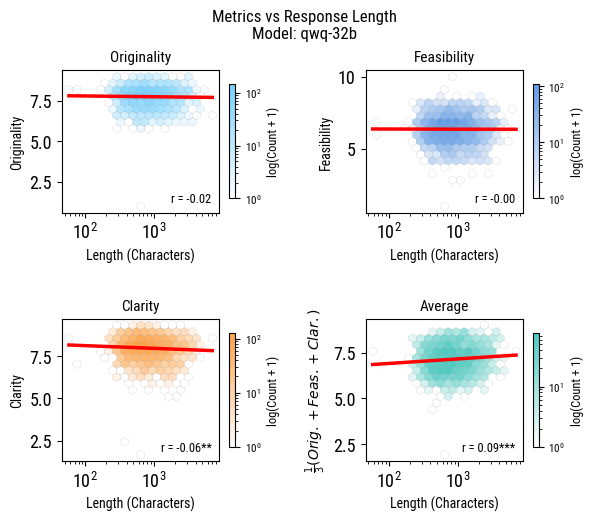


Pearson Correlations for model: qwen/qwq-32b (Aggregated Data: log10(length) vs mean metric)
  originality:    r = -0.021 (p=0.309)
  feasibility:    r = -0.003 (p=0.881)
  clarity:        r = -0.061** (p=0.00321)
  avg:            r = 0.091*** (p=1.14e-05)

--- Plotting for model: google/gemini-2.0-flash-thinking-exp:free ---
Model google/gemini-2.0-flash-thinking-exp:free - Aggregated Response Length Description:
count    2372.000000
mean       80.876054
std        11.824913
min        44.000000
25%        73.000000
50%        81.000000
75%        88.000000
max       137.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_google_gemini-2.0-flash-thinking-exp_free.pdf


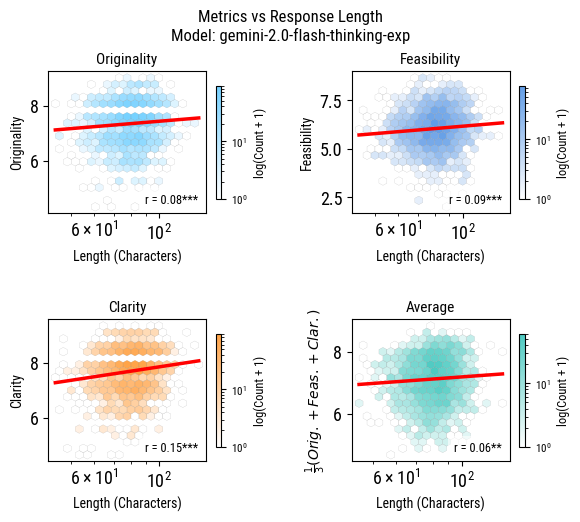


Pearson Correlations for model: google/gemini-2.0-flash-thinking-exp:free (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.081*** (p=8.29e-05)
  feasibility:    r = 0.089*** (p=1.33e-05)
  clarity:        r = 0.146*** (p=1.05e-12)
  avg:            r = 0.063** (p=0.00224)

--- Plotting for model: deepseek/deepseek-r1-distill-llama-70b ---
Model deepseek/deepseek-r1-distill-llama-70b - Aggregated Response Length Description:
count    1867.000000
mean      454.928763
std       237.780567
min        97.000000
25%       309.000000
50%       399.000000
75%       523.000000
max      2248.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_deepseek_deepseek-r1-distill-llama-70b.pdf


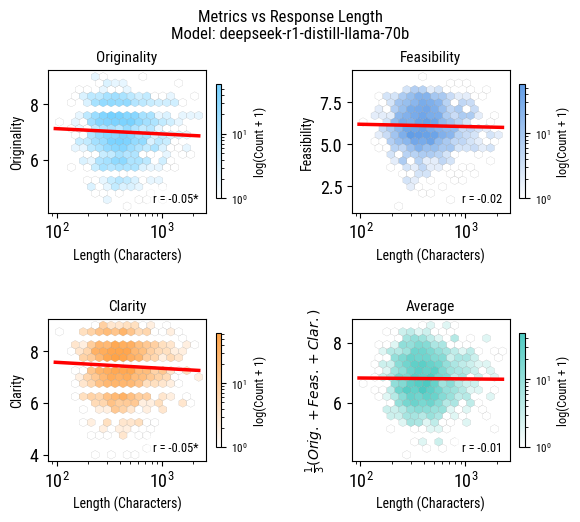


Pearson Correlations for model: deepseek/deepseek-r1-distill-llama-70b (Aggregated Data: log10(length) vs mean metric)
  originality:    r = -0.046* (p=0.0472)
  feasibility:    r = -0.024 (p=0.296)
  clarity:        r = -0.051* (p=0.0276)
  avg:            r = -0.008 (p=0.733)

--- Plotting for model: qwen/qwq-32b-preview ---
Model qwen/qwq-32b-preview - Aggregated Response Length Description:
count     2229.000000
mean      1293.230148
std       1056.158986
min         20.000000
25%        835.000000
50%       1136.000000
75%       1511.000000
max      23901.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_qwen_qwq-32b-preview.pdf


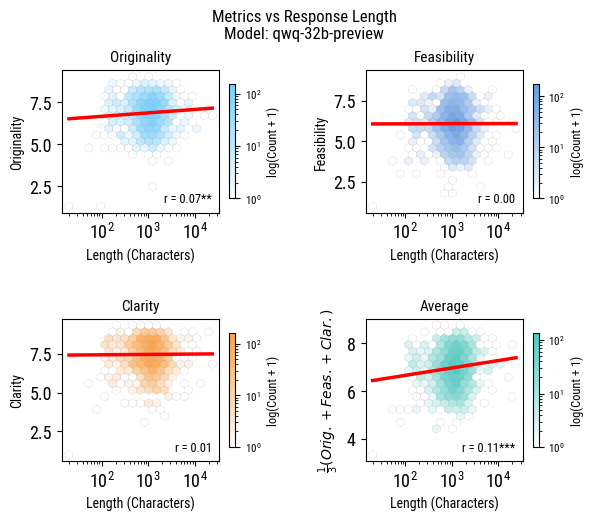


Pearson Correlations for model: qwen/qwq-32b-preview (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.066** (p=0.00186)
  feasibility:    r = 0.002 (p=0.924)
  clarity:        r = 0.007 (p=0.745)
  avg:            r = 0.112*** (p=2.72e-07)

--- Plotting for model: anthropic/claude-3.7-sonnet:thinking ---
Model anthropic/claude-3.7-sonnet:thinking - Aggregated Response Length Description:
count    2375.000000
mean     1545.838316
std       503.535256
min        98.000000
25%      1239.000000
50%      1511.000000
75%      1822.000000
max      4906.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_anthropic_claude-3.7-sonnet_thinking.pdf


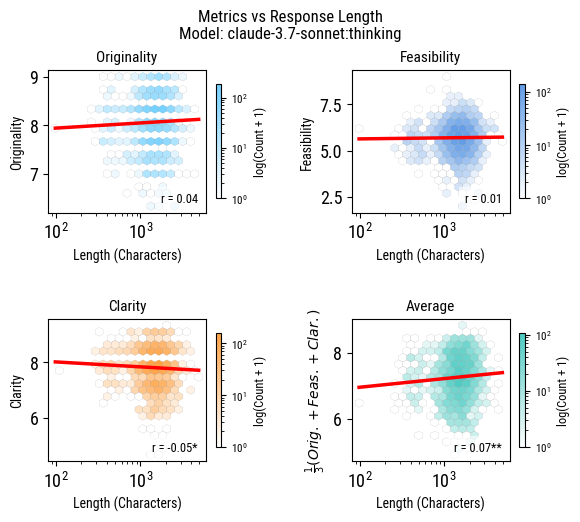


Pearson Correlations for model: anthropic/claude-3.7-sonnet:thinking (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.035 (p=0.0851)
  feasibility:    r = 0.011 (p=0.585)
  clarity:        r = -0.046* (p=0.0242)
  avg:            r = 0.067** (p=0.00114)

--- Plotting for model: deepseek/deepseek-r1 ---
Model deepseek/deepseek-r1 - Aggregated Response Length Description:
count    2373.000000
mean      515.754741
std       258.769951
min       129.000000
25%       334.000000
50%       454.000000
75%       627.000000
max      2867.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_deepseek_deepseek-r1.pdf


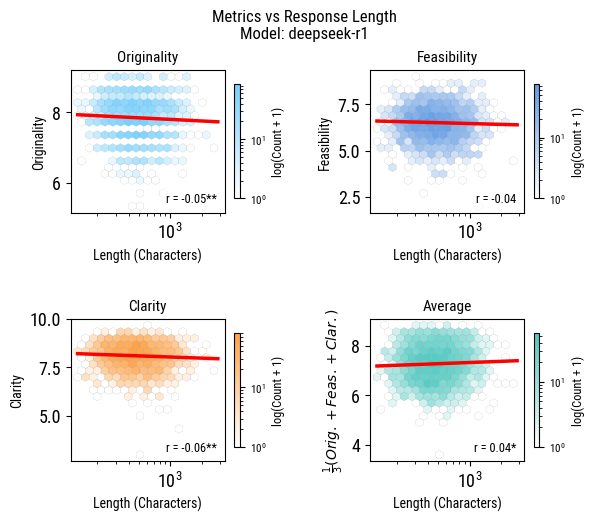


Pearson Correlations for model: deepseek/deepseek-r1 (Aggregated Data: log10(length) vs mean metric)
  originality:    r = -0.053** (p=0.00926)
  feasibility:    r = -0.036 (p=0.0829)
  clarity:        r = -0.060** (p=0.00359)
  avg:            r = 0.044* (p=0.0322)

--- Plotting for model: deepseek/deepseek-r1-distill-qwen-32b ---
Model deepseek/deepseek-r1-distill-qwen-32b - Aggregated Response Length Description:
count    2249.000000
mean      507.879947
std       337.642337
min        65.000000
25%       321.000000
50%       412.000000
75%       571.000000
max      4504.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_deepseek_deepseek-r1-distill-qwen-32b.pdf


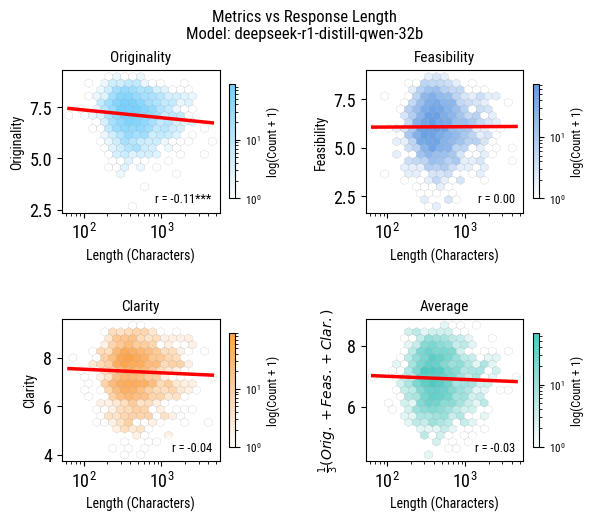


Pearson Correlations for model: deepseek/deepseek-r1-distill-qwen-32b (Aggregated Data: log10(length) vs mean metric)
  originality:    r = -0.106*** (p=4.32e-07)
  feasibility:    r = 0.004 (p=0.864)
  clarity:        r = -0.037 (p=0.0817)
  avg:            r = -0.032 (p=0.149)

--- Plotting for model: openai/o1 ---
Model openai/o1 - Aggregated Response Length Description:
count    2377.000000
mean       76.353807
std        12.715143
min        41.000000
25%        67.000000
50%        78.000000
75%        86.000000
max       100.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_openai_o1.pdf


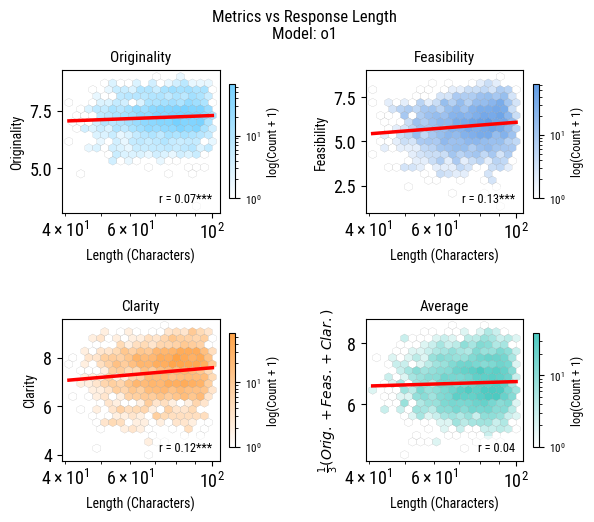


Pearson Correlations for model: openai/o1 (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.069*** (p=0.000776)
  feasibility:    r = 0.126*** (p=7.88e-10)
  clarity:        r = 0.123*** (p=1.63e-09)
  avg:            r = 0.040 (p=0.0507)

--- Plotting for model: openai/o3-mini-high ---
Model openai/o3-mini-high - Aggregated Response Length Description:
count    2375.000000
mean       71.861474
std         8.232035
min        42.000000
25%        66.000000
50%        72.000000
75%        78.000000
max        98.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_openai_o3-mini-high.pdf


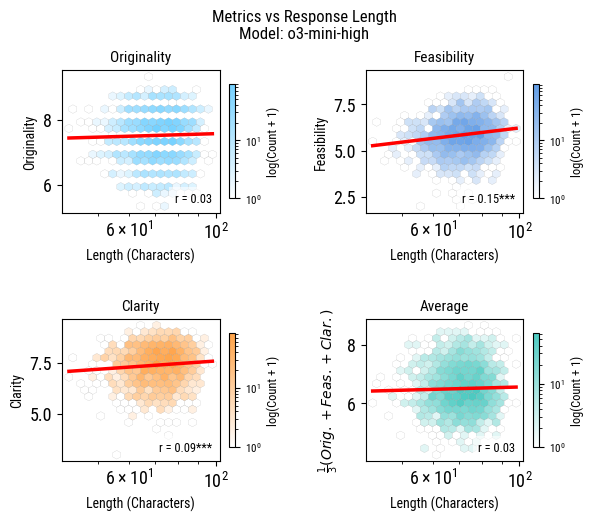


Pearson Correlations for model: openai/o3-mini-high (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.028 (p=0.176)
  feasibility:    r = 0.150*** (p=1.95e-13)
  clarity:        r = 0.088*** (p=1.58e-05)
  avg:            r = 0.026 (p=0.203)

--- Plotting for model: openai/o3-mini ---
Model openai/o3-mini - Aggregated Response Length Description:
count    2376.000000
mean       70.369949
std         9.374362
min        41.000000
25%        64.000000
50%        70.500000
75%        77.000000
max        95.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_openai_o3-mini.pdf


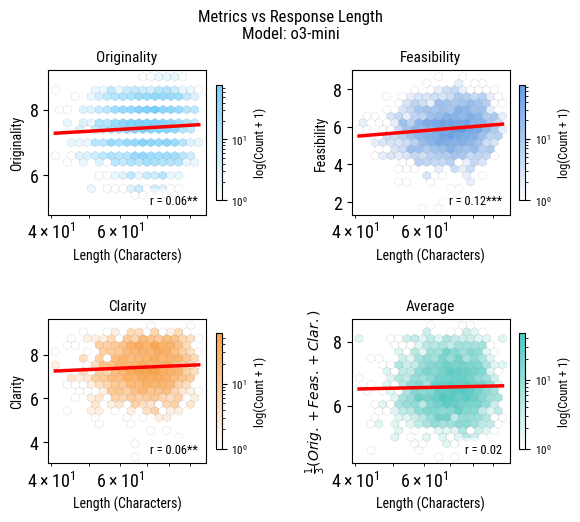


Pearson Correlations for model: openai/o3-mini (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.065** (p=0.00158)
  feasibility:    r = 0.116*** (p=1.33e-08)
  clarity:        r = 0.058** (p=0.00487)
  avg:            r = 0.023 (p=0.263)

--- Plotting for model: openai/o1-mini ---
Model openai/o1-mini - Aggregated Response Length Description:
count    2376.000000
mean       94.875000
std         8.209824
min        47.000000
25%        90.000000
50%        95.000000
75%       100.000000
max       127.000000
Name: full_response_length, dtype: float64
  Metric: originality
  Metric: feasibility
  Metric: clarity
  Metric: avg
  Plot saved to: figs/SI_length_hexbin_openai_o1-mini.pdf


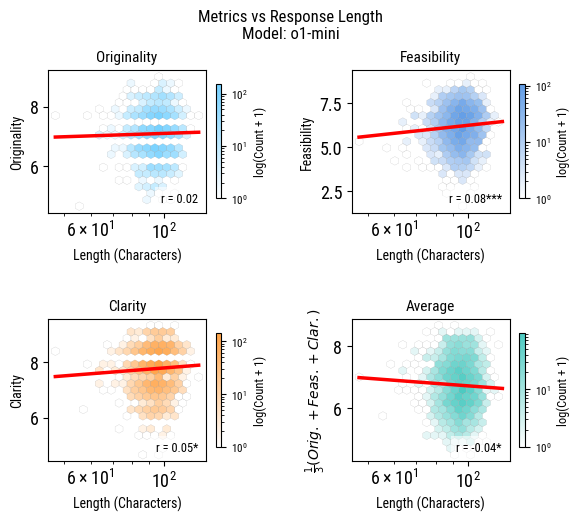


Pearson Correlations for model: openai/o1-mini (Aggregated Data: log10(length) vs mean metric)
  originality:    r = 0.022 (p=0.292)
  feasibility:    r = 0.079*** (p=0.000109)
  clarity:        r = 0.053* (p=0.0104)
  avg:            r = -0.043* (p=0.037)

Script finished.


In [55]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Needed for LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import os

# --- !!! Assume df is already loaded here !!! ---
# Example: df = pd.read_csv('your_data.csv')
# Ensure your df has columns: 'idea_model', 'idea', 'full_response', 'originality', 'feasibility', 'clarity', 'avg'

# --- Configuration ---
is_plot = True

if is_plot and 'df' in locals():
    # --- Define Models to Plot ---
    keywords_to_plot = ["qwq", "thinking", "reasoning", "r1", "o1", "o3"]
    if 'idea_model' not in df.columns:
        print("Error: 'idea_model' column not found in DataFrame.")
        is_plot = False
    else:
        all_model_names = df['idea_model'].dropna().unique()
        models_to_plot = [name for name in all_model_names if any(keyword in name for keyword in keywords_to_plot)]
        print(f"Found models to plot based on keywords: {models_to_plot}")
        if not models_to_plot:
            print("No models found matching the keywords. Skipping plotting.")
            is_plot = False

if is_plot and 'df' in locals():
    # --- Ensure Output Directory Exists ---
    output_dir = 'figs'
    os.makedirs(output_dir, exist_ok=True)

    # --- Pre-processing and Aggregation ---
    print("\n--- Aggregating data by 'idea_model' and 'idea' ---")
    if 'full_response' not in df.columns:
         print("Error: 'full_response' column not found.")
         is_plot = False
    else:
        df['full_response_length'] = df['full_response'].apply(
            lambda x: len(str(x).split()) if pd.notna(x) and isinstance(x, str) else 0
        )

    metrics_to_aggregate = ['originality', 'feasibility', 'clarity', 'avg']
    aggregation_columns = metrics_to_aggregate + ['full_response_length']
    required_cols = ['idea_model', 'idea'] + aggregation_columns
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Error: Missing required columns for aggregation: {missing_cols}.")
        is_plot = False
    elif 'idea' not in df.columns:
         print("Error: 'idea' column not found.")
         is_plot = False
    else:
        agg_funcs = {metric: 'mean' for metric in metrics_to_aggregate}
        agg_funcs['full_response_length'] = 'first'
        try:
            df_subset = df[['idea_model', 'idea'] + aggregation_columns].copy()
            df_agg = df_subset.groupby(['idea_model', 'idea']).agg(agg_funcs).reset_index()
            print(f"Aggregation complete. Original rows: {len(df)}, Aggregated rows: {len(df_agg)}")
        except KeyError as e:
            print(f"Error during aggregation: Missing column {e}.")
            is_plot = False
        except Exception as e:
            print(f"An unexpected error occurred during aggregation: {e}")
            is_plot = False

# --- Plotting Section (only if is_plot is still True) ---
if is_plot and 'df_agg' in locals():

    # --- Helper Function for p-value stars ---
    def get_p_stars(p_value):
        if p_value is None or pd.isna(p_value): return ""
        if p_value < 0.001: return '***'
        elif p_value < 0.01: return '**'
        elif p_value < 0.05: return '*'
        else: return ''

    # --- Metrics and Plotting Setup ---
    metrics_to_plot = ['originality', 'feasibility', 'clarity', 'avg']
    dict_name = {
        'originality': 'Originality',
        'feasibility': 'Feasibility',
        'clarity': 'Clarity',
        # 'avg': 'Average',
        'avg': r'$\frac{1}{3}(Orig. + Feas. + Clar.)$'
    }
    target_colors = ['#66ccff', '#5092e4', '#ff9933', '#39C5BB']
    # --- REMOVED Fixed Y-axis limits ---
    # y_axis_limits = (0.5, 5.5) # Removed

    # --- Loop Through Each Model using the Aggregated Data ---
    for model_name in models_to_plot:
        print(f"\n--- Plotting for model: {model_name} ---")

        df_model = df_agg[df_agg['idea_model'] == model_name].copy()
        df_model = df_model[df_model['full_response_length'] > 0]

        if df_model.empty:
            print(f"Skipping model {model_name}.")
            continue

        df_model['log_length'] = np.log10(df_model['full_response_length'])

        print(f"Model {model_name} - Aggregated Response Length Description:")
        print(df_model['full_response_length'].describe())

        # --- Create Plot Figure for the Current Model ---
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6))

        axes = [ax1, ax2, ax3, ax4]

        for i, metric in enumerate(metrics_to_plot):
            print(f'  Metric: {metric}')
            ax = axes[i]

            if metric not in df_model.columns:
                print(f"  Metric '{metric}' not found.")
                ax.set_title(f"{dict_name.get(metric, metric)}\n(Data Missing)")
                ax.text(0.5, 0.5, "Data Missing", ha='center', va='center', transform=ax.transAxes)
                continue

            mask = pd.notna(df_model['log_length']) & pd.notna(df_model[metric])
            clean_df = df_model[mask]

            if clean_df.empty or len(clean_df) < 2:
                print(f"  Skipping plot for metric '{metric}' due to insufficient data.")
                ax.set_title(f"{dict_name.get(metric, metric)}\n(Insufficient Data)")
                ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center', transform=ax.transAxes)
                continue

            # --- Setup for Hexbin ---
            grid_size = 18 # Keep gridsize adjustment
            target_color = target_colors[i]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list(f'cmap_{metric}', ['#FFFFFF', target_color])

            try:
                x_data = clean_df['full_response_length']
                y_data = clean_df[metric]
                log_x_data = clean_df['log_length']

                valid_x_mask = x_data > 0
                if not valid_x_mask.all():
                    print(f"Warning: Filtering non-positive lengths for {metric}.")
                    x_data = x_data[valid_x_mask]
                    y_data = y_data[valid_x_mask]
                    log_x_data = log_x_data[valid_x_mask]
                    if len(x_data) < 2: raise ValueError("Not enough data after filtering.")

                # --- Plot Hexbin ---
                hb = ax.hexbin(
                    x=x_data,
                    y=y_data,
                    gridsize=grid_size,
                    cmap=custom_cmap,
                    bins='log',
                    mincnt=1,
                    xscale='log',
                    alpha=0.9,
                    edgecolors='grey',
                    linewidths=0.1
                )
                # --- REMOVED Setting Y limits ---
                # ax.set_ylim(y_axis_limits) # Removed

                cb = fig.colorbar(hb, ax=ax, shrink=0.8)
                cb.set_label('log(Count + 1)', fontsize=9)
                cb.ax.tick_params(labelsize=8)

            except ValueError as e:
                 print(f"  Skipping hexbin for metric '{metric}' due to error: {e}")
                 ax.set_title(f"{dict_name.get(metric, metric)}\n(Plotting Error)")
                 ax.text(0.5, 0.5, "Plotting Error", ha='center', va='center', transform=ax.transAxes)
                 continue

            # --- Calculate and Plot Regression Line ---
            pearson_r, p_value = np.nan, np.nan
            try:
                # Check for sufficient variance before polyfit and pearsonr
                if len(log_x_data.unique()) > 1 and len(y_data.unique()) > 1:
                    slope, intercept = np.polyfit(log_x_data, y_data, 1)
                    min_len_log = log_x_data.min()
                    max_len_log = log_x_data.max()

                    x_range_log = np.linspace(min_len_log, max_len_log, 100)
                    y_pred = slope * x_range_log + intercept

                    # --- REMOVED Clipping of y_pred ---
                    # y_pred_clipped = np.clip(y_pred, y_axis_limits[0], y_axis_limits[1]) # Removed
                    # Plot the original y_pred
                    ax.plot(np.power(10, x_range_log), y_pred, 'r-', linewidth=2.5, label='Log-Linear Fit')

                    # Calculate Pearson correlation
                    pearson_r, p_value = stats.pearsonr(log_x_data, y_data)
                else:
                   print(f"  Cannot calculate regression/correlation for {metric}: insufficient variance.")
                   # Optionally, still plot hexbin but skip line and annotation
                   # Or handle as needed

            except Exception as e:
                print(f"  Could not compute regression/correlation for {metric}: {e}")

            # --- Add Pearson r and p-value stars text (only if calculated) ---
            if pd.notna(pearson_r):
                stars = get_p_stars(p_value)
                r_text = f'r = {pearson_r:.2f}'
                annotation_text = f'{r_text}{stars}'
                ax.text(0.95, 0.05, annotation_text, transform=ax.transAxes,
                        horizontalalignment='right', verticalalignment='bottom', fontsize=9,
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            elif len(clean_df) >= 2 : # Add annotation only if r is NaN due to variance, not lack of points
                 ax.text(0.95, 0.05, "r = n/a", transform=ax.transAxes,
                        horizontalalignment='right', verticalalignment='bottom', fontsize=9,
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))


            # --- Set labels and title ---
            ax.set_xlabel('Length (Characters)', fontsize=10)
            ax.set_ylabel(dict_name.get(metric, metric), fontsize=10)
            ax.set_title(dict_name.get(metric, metric).replace(r'$\frac{1}{3}(Orig. + Feas. + Clar.)$','Average'), fontsize=11)
            # Y limits are now automatic

        # --- Final Touches for the Figure ---
        # plt.suptitle(f'Metrics vs Response Length (Aggregated, Log Counts)\nModel: {model_name}', fontsize=12, y=0.9)
        plt.suptitle(f'Metrics vs Response Length\nModel: {clean_model_name(model_name)}', fontsize=12, y=0.9)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=2.0, w_pad=2.0)

        safe_model_name = model_name.replace('/', '_').replace('\\', '_').replace(':', '_')
        output_filename = os.path.join(output_dir, f'SI_length_hexbin_{safe_model_name}.pdf') # Updated filename again
        plt.savefig(output_filename, bbox_inches='tight')
        print(f"  Plot saved to: {output_filename}")
        plt.show()
        plt.close(fig)

        # --- Print correlations ---
        print(f"\nPearson Correlations for model: {model_name} (Aggregated Data: log10(length) vs mean metric)")
        for metric in metrics_to_plot:
            if metric in df_model.columns:
                mask = pd.notna(df_model['log_length']) & pd.notna(df_model[metric])
                clean_df = df_model[mask]
                log_length_corr = clean_df['log_length']
                metric_corr = clean_df[metric]
                # Check variance again before printing correlation
                if len(clean_df) > 2 and len(log_length_corr.unique()) > 1 and len(metric_corr.unique()) > 1:
                    try:
                        # Recalculate here just for printing consistency, though pearson_r/p_value might exist from plot loop
                        correlation, p_val = stats.pearsonr(log_length_corr, metric_corr)
                        stars = get_p_stars(p_val)
                        print(f"  {metric + ':':<15} r = {correlation:.3f}{stars} (p={p_val:.3g})")
                    except ValueError as e: # Should be caught by variance check, but safety first
                        print(f"  {metric + ':':<15} Could not calculate Pearson r (Error: {e})")
                else:
                    print(f"  {metric + ':':<15} N/A (insufficient data/variance)")

elif not ('df' in locals()):
    print("DataFrame 'df' not found.")
elif not is_plot:
    print("Plotting was disabled.")

print("\nScript finished.")

In [56]:
colors

['#52ccc3', '#5092e4', '#66ccff', '#9673a6', '#ff6b6b']

2025-04-09 22:37:33,058 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 22:37:33,139 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


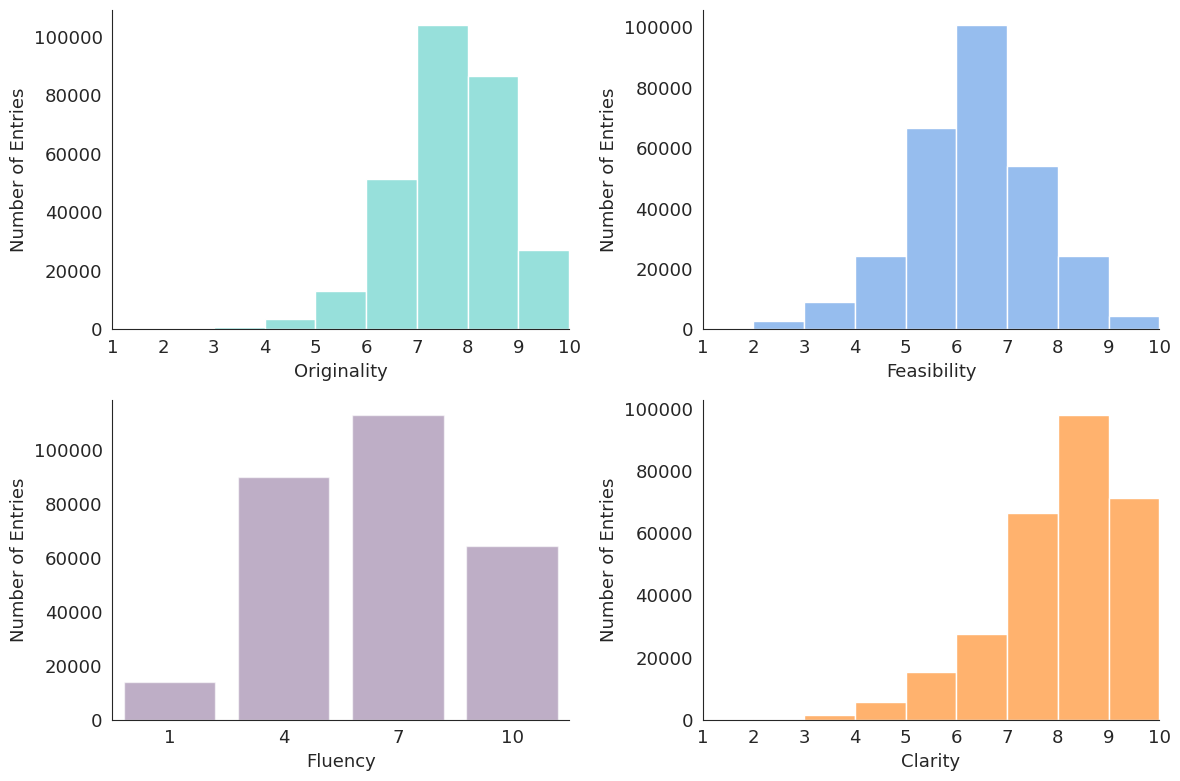

In [ ]:
# Check if plotting is enabled
if is_plot:
    # Set the Seaborn style to "white"
    sns.set_style("white")
    # Import plotting libraries (only if plotting)
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Flatten the axes array for easier indexing
    ax1, ax2, ax3, ax4 = axes.flatten()

    # First plot - Originality (Top Left)
    sns.histplot(data=df, x='originality', bins=range(11), stat='count', color=colors[0], alpha=0.6, ax=ax1)
    ax1.set_xlim(1, 10)  # Set x-axis limits
    ax1.set_xticks(range(1, 11)) # Set x-axis ticks
    sns.despine(ax=ax1) # Remove top and right spines
    ax1.set_xlabel('Originality') # Set x-axis label
    ax1.set_ylabel('Number of Entries') # Set y-axis label
    ax1.grid(False) # Disable grid

    # Second plot - Feasibility (Top Right)
    sns.histplot(data=df, x='feasibility', bins=range(11), stat='count', color=colors[1], alpha=0.6, ax=ax2)
    ax2.set_xlim(1, 10) # Set x-axis limits
    ax2.set_xticks(range(1, 11)) # Set x-axis ticks
    sns.despine(ax=ax2) # Remove top and right spines
    ax2.set_xlabel('Feasibility') # Set x-axis label
    ax2.set_ylabel('Number of Entries') # Set y-axis label
    ax2.grid(False) # Disable grid

    # Third plot - Fluency (Bottom Left)
    # Since Fluency has specific discrete values, countplot is more appropriate
    sns.countplot(data=df, x='flue', color='#9673a6', alpha=0.6, ax=ax3)
    ax3.set_xlim(-0.5, 3.5)  # Adjust limits to accommodate discrete values
    ax3.set_xticks(range(4)) # Set positions for x-axis ticks
    ax3.set_xticklabels(['1', '4', '7', '10'])  # Set specific value labels for ticks
    sns.despine(ax=ax3) # Remove top and right spines
    ax3.set_xlabel('Fluency') # Set x-axis label
    ax3.set_ylabel('Number of Entries') # Set y-axis label
    ax3.grid(False) # Disable grid

    # Fourth plot - Clarity (Bottom Right)
    sns.histplot(data=df, x='clarity', bins=range(11), stat='count', color='#ff7f0e', alpha=0.6, ax=ax4) # Elegant orange color
    ax4.set_xlim(1, 10) # Set x-axis limits
    ax4.set_xticks(range(1, 11)) # Set x-axis ticks
    sns.despine(ax=ax4) # Remove top and right spines
    ax4.set_xlabel('Clarity') # Set x-axis label
    ax4.set_ylabel('Number of Entries') # Set y-axis label
    ax4.grid(False) # Disable grid

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()
    # Save the figure to a PDF file
    plt.savefig('figs/distribution_combined.pdf')
    # Display the plot
    plt.show()

# to huggingface 

In [58]:
# df_hf = df.drop(['timestamp','parsed_feedback','error','timestamp_int','mean_score','min_score','idea_hash'], axis=1)
df_hf = df.drop(['timestamp','error','mean_score','min_score','idea_hash'], axis=1)
# drop nan
# df_hf = df_hf.dropna()
# to huggface format
# df_hf.to_csv('liveideabench_hf.csv')

In [59]:
df_hf.idea_model.unique()

array(['qwen/qwq-32b', 'google/gemini-2.0-flash-exp:free',
       'google/gemini-2.0-flash-thinking-exp:free',
       'deepseek/deepseek-chat', 'deepseek/deepseek-r1-distill-llama-70b',
       'qwen/qwq-32b-preview', 'anthropic/claude-3.7-sonnet:thinking',
       'google/gemini-2.0-pro-exp-02-05:free', 'deepseek/deepseek-r1',
       'anthropic/claude-3.5-haiku-20241022',
       'deepseek/deepseek-r1-distill-qwen-32b', 'openai/o1',
       'openai/gpt-4.5-preview', 'mistralai/mistral-large-2411',
       'openai/o3-mini-high', 'amazon/nova-lite-v1',
       'sammcj/qwen2.5-dracarys2-72b:Q4_K_M',
       'meta-llama/llama-3.1-405b-instruct', 'openai/o3-mini',
       'openai/gpt-4o-2024-11-20', 'openai/gpt-4o-mini',
       'google/gemma-2-27b-it',
       'mistralai/mistral-small-24b-instruct-2501', 'openai/gpt-4-turbo',
       'mistralai/mistral-small', 'openai/o1-mini',
       'meta-llama/llama-3.1-70b-instruct', 'qwen/qwen-2.5-72b-instruct',
       'x-ai/grok-2-1212', 'google/gemini-2.0-fla

In [60]:
df_hf.describe()

id  parsed_reasoning  first_was_rejected  \
count  286492.000000               0.0       286492.000000   
mean   143801.512552               NaN            0.000478   
std     83004.709573               NaN            0.021863   
min         1.000000               NaN            0.000000   
25%     71908.750000               NaN            0.000000   
50%    143792.500000               NaN            0.000000   
75%    215608.250000               NaN            0.000000   
max    287697.000000               NaN            1.000000   

       idea_length_in_char  idea_length_in_words    originality  \
count        286492.000000         286492.000000  286492.000000   
mean            700.635365             88.050158       7.166954   
std             160.694412             20.048586       1.094805   
min             101.000000              1.000000       0.000000   
25%             606.000000             77.000000       7.000000   
50%             708.000000             89.000000       7.000000   
75%             787.000000             98.000000       8.000000   
max            1672.000000            199.000000      10.000000   

         feasibility        clarity           flue            avg  \
count  286492.000000  286492.000000  281090.000000  281090.000000   
mean        5.858628       7.555956       6.426778       6.751379   
std         1.303346       1.288438       2.530690       0.899106   
min        -6.000000       0.000000       1.000000       0.250000   
25%         5.000000       7.000000       4.000000       6.250000   
50%         6.000000       8.000000       7.000000       6.750000   
75%         7.000000       8.000000       7.000000       7.500000   
max        14.000000      10.000000      10.000000       9.500000   

       full_response_length  
count         286492.000000  
mean             199.870656  
std              390.556113  
min                0.000000  
25%               78.000000  
50%               91.000000  
75%              102.000000  
max            23901.000000

In [ ]:
cols = df_hf.columns
cols = list(cols)
cols

['id',
 'keywords',
 'idea_model',
 'critic_model',
 'idea',
 'raw_critique',
 'parsed_scores',
 'parsed_reasoning',
 'critique_reasoning',
 'full_response',
 'first_was_rejected',
 'first_reject_response',
 'idea_length_in_char',
 'idea_length_in_words',
 'scores',
 'originality',
 'feasibility',
 'clarity',
 'flue',
 'avg',
 'full_response_length']

In [62]:
for i in range(len(cols)):
    if cols[i] == 'elab':
        cols[i] = 'feas'
    if cols[i] == 'flue':
        cols[i] = 'fluency'
cols

['id',
 'keywords',
 'idea_model',
 'critic_model',
 'idea',
 'raw_critique',
 'parsed_scores',
 'parsed_reasoning',
 'critique_reasoning',
 'full_response',
 'first_was_rejected',
 'first_reject_response',
 'idea_length_in_char',
 'idea_length_in_words',
 'scores',
 'originality',
 'feasibility',
 'clarity',
 'fluency',
 'avg',
 'full_response_length']

In [63]:
df_hf.columns = cols
df_hf = df_hf[[
 'keywords',
 'idea_model',
 'critic_model',
 'idea',
 'raw_critique',
 'parsed_scores',
 'critique_reasoning',
 'full_response',
 'first_was_rejected',
 'first_reject_response',
 'idea_length_in_char',
 'idea_length_in_words',
 'scores',
 'originality',
 'feasibility',
 'clarity',
 'fluency',
 'avg',
 'full_response_length']]
df_hf.to_csv('./csvs/liveideabench_hf.csv',index=None)

In [64]:
import pandas as pd

# df = pd.read_csv("hf://datasets/6cf/liveideabench/liveideabench_hf.csv")

In [65]:
df_hf

keywords          idea_model  \
0                        ecodesign        qwen/qwq-32b   
1                        ecodesign        qwen/qwq-32b   
2                        ecodesign        qwen/qwq-32b   
3                civil engineering        qwen/qwq-32b   
4                civil engineering        qwen/qwq-32b   
...                            ...                 ...   
287692               neutron stars  openai/gpt-4o-mini   
287693               neutron stars  openai/gpt-4o-mini   
287694  statistical thermodynamics  openai/gpt-4o-mini   
287695  statistical thermodynamics  openai/gpt-4o-mini   
287696  statistical thermodynamics  openai/gpt-4o-mini   

                                critic_model  \
0                        openai/o3-mini-high   
1       anthropic/claude-3.7-sonnet:thinking   
2                     openai/gpt-4.5-preview   
3                        openai/o3-mini-high   
4                              qwen/qwen-max   
...                                      ...   
287692  anthropic/claude-3.7-sonnet:thinking   
287693                   openai/o3-mini-high   
287694                   openai/o3-mini-high   
287695  google/gemini-2.0-pro-exp-02-05:free   
287696                         qwen/qwen-max   

                                                     idea  \
0       **Idea:** **Problem:** Current ecodesign relie...   
1       **Idea:** **Problem:** Current ecodesign relie...   
2       **Idea:** **Problem:** Current ecodesign relie...   
3       **Background:** Aging civil infrastructure fac...   
4       **Background:** Aging civil infrastructure fac...   
...                                                   ...   
287692  Neutron stars, the remnants of supernovae, are...   
287693  Neutron stars, the remnants of supernovae, are...   
287694  Statistical thermodynamics bridges macroscopic...   
287695  Statistical thermodynamics bridges macroscopic...   
287696  Statistical thermodynamics bridges macroscopic...   

                                             raw_critique  \
0       The idea is innovative in embedding sustainabi...   
1       The AI-CAD plug-in concept addresses a signifi...   
2       The proposed idea addresses a significant unme...   
3       The idea offers an interesting integration of ...   
4       **Analysis:** The idea of integrating self-hea...   
...                                                   ...   
287692  The idea proposes a dedicated gravitational wa...   
287693  The proposal is clearly articulated and effect...   
287694  The proposal ingeniously blends statistical th...   
287695  This idea proposes using machine learning, gui...   
287696  **Analysis:** The idea proposes a machine-lear...   

                                            parsed_scores  \
0       {'originality': 8, 'feasibility': 6, 'clarity'...   
1       {'originality': 7, 'feasibility': 6, 'clarity'...   
2       {'originality': 9, 'feasibility': 6, 'clarity'...   
3       {'originality': 7, 'feasibility': 6, 'clarity'...   
4       {'originality': 8, 'feasibility': 6, 'clarity'...   
...                                                   ...   
287692  {'originality': 4, 'feasibility': 6, 'clarity'...   
287693  {'originality': 5, 'feasibility': 6, 'clarity'...   
287694  {'originality': 8, 'feasibility': 7, 'clarity'...   
287695  {'originality': 7, 'feasibility': 5, 'clarity'...   
287696  {'originality': 6, 'feasibility': 5, 'clarity'...   

                                       critique_reasoning  \
0                                                    None   
1       Let me evaluate this AI-CAD plug-in idea for r...   
2                                                    None   
3                                                    None   
4                                                    None   
...                                                   ...   
287692  Let's break down this idea and evaluate it acr...   
287693                                               None   
2876